**Spark notebook**

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))


# Print function docstrings

help(start_spark)
help(stop_spark)
help(display_spark)
help(show_as_html)

Help on function start_spark in module __main__:

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)
    Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)

Help on function stop_spark in module __main__:

stop_spark()
    Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).

Help on function display_spark in module __main__:

display_spark()
    Display the status of the active Spark session if one is currently running.

Help on function show_as_html in module __main__:

show_as_html(df, n=20)
    Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n 

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=4, worker_memory=8, master_memory=4)

In [3]:
# Write your imports and code here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
import textwrap
import glob
import math as m
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import pandas as pd
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/users/home/mda205/.local/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
def savefile(filename, tablename):

    name = "mda205"

    data_path = f"hdfs:///user/{name}/outputs/{filename}/"


    tablename.write.mode("overwrite").csv(data_path)
    
    (tablename.write
        .option("compression", "gzip")
        .mode("overwrite")
        .csv(data_path))
    
def get_daily_data_for_select_year(startyear, endyear=False):
    
    """retreive data for specified year or years. if only looking at one year,
    startyear is treated as target year. enter years as integers and in chronological order
    endyear defaults to false if no second argument is given"""
    
    if endyear != False:
        
        years=range(startyear, endyear + 1)

        yearsconcat="{"+",".join([f"{year}" for year in years])+"}*"
        
        filepath=("hdfs:///data/ghcnd/daily/"+yearsconcat+"*")
       
    elif endyear==False:
        targetYear=f'{startyear}'
        
        filepath=("hdfs:///data/ghcnd/daily/"+targetYear+"*")

    data=(
        spark.read.format("com.databricks.spark.csv")
        .option("header", "false")
        .option("inferSchema", "false")
        .option("dateFormat", "yyyymmdd")
        .schema(schema_daily).load(filepath))
    
    return data

In [5]:
schema_stations = StructType([
    StructField("Station_ID", StringType(), True),
    StructField("State_Code", StringType(), True),
    StructField("Country_Code", StringType(), True),
    StructField("Lat", DoubleType(), True),
    StructField("Lon", DoubleType(), True),
    StructField("Elevation", IntegerType(), True),
    StructField("Station_Name", StringType(), True),
    StructField("GSN_flag", StringType(), True),
    StructField("HCN_flag", StringType(), True),
    StructField("WMO_ID", IntegerType(), True),
    StructField("Country_Name", StringType(), True),
    StructField("State_Name", StringType(), True),
    StructField("Station_Elements", StringType(), True),
    StructField("FirstYear", IntegerType(), True),
    StructField("LastYear", IntegerType(), True),
    StructField("Element_Count", IntegerType(), True),
    StructField("Core_Element_Count", IntegerType(), True),
    StructField("Not_Core_Elements", IntegerType(), True)
])

stations=(
    spark.read.format("com.databricks.spark.csv")
    .option("header", "False")
    .option("inferSchema", "False")
    .schema(schema_stations)
    .load("hdfs:///user/mda205/outputs/no_array_stations"))

schema_daily = StructType([
    StructField("Station_ID", StringType(), True),
    StructField("DATE", DateType(), True),
    StructField("Element", StringType(), True),
    StructField("Element_Value", IntegerType(), True),
    StructField("MEASUREMENT_FLAG", StringType(), True),
    StructField("QUALITY_FLAG", StringType(), True),
    StructField("SOURCE_FLAG", StringType(), True),
    StructField("OBSERVATION_TIME", StringType(), True),
])



core_elements=["PRCP","SNOW","SNWD","TMAX","TMIN"]

In [6]:
stations_broadcasted=F.broadcast(stations)

Q4 a

In [7]:
all_daily=get_daily_data_for_select_year(1750, 2023)

In [8]:
# dont need to run this again

# rows_in_daily=all_daily.count()

# print(f"The total number of rows of Daily data is {rows_in_daily}")

Q4 B

In [9]:
# i most certainly could have filtered this more but thats hindsight
core_elements_daily=(all_daily.filter(
    F.col("Element").isin(core_elements)))

In [10]:
# i thought this would be more efficient than what i first tried below but they both took the same 
# amount of time and stages/tasks
core_elements_daily.groupBy(["Element"]).count().show()

+-------+----------+
|Element|     count|
+-------+----------+
|   PRCP|1057396673|
|   TMAX| 451364119|
|   SNWD| 294454702|
|   SNOW| 348203650|
|   TMIN| 450155708|
+-------+----------+



In [11]:
# I don't like this and know it's not very efficient but I only needed to do it once to get the counts
# weirly this took the same amount of time as groupby.count which i would have thought is faster
Core_Element_Counts=(
    core_elements_daily.select(
    F.count(F.when((F.col("Element") == core_elements[0]), 1)).alias(f'{core_elements[0]} count'),
    F.count(F.when((F.col("Element") == core_elements[1]), 1)).alias(f'{core_elements[1]} count'),
    F.count(F.when((F.col("Element") == core_elements[2]), 1)).alias(f'{core_elements[2]} count'),
    F.count(F.when((F.col("Element") == core_elements[3]), 1)).alias(f'{core_elements[3]} count'),
    F.count(F.when((F.col("Element") == core_elements[4]), 1)).alias(f'{core_elements[4]} count')))

Core_Element_Counts.show()

+----------+----------+----------+----------+----------+
|PRCP count|SNOW count|SNWD count|TMAX count|TMIN count|
+----------+----------+----------+----------+----------+
|1057396673| 348203650| 294454702| 451364119| 450155708|
+----------+----------+----------+----------+----------+



Q4 C

In [12]:
daily_temp_obs_only=(core_elements_daily
               .where(
                   (F.col("Element")== "TMIN") | 
                   (F.col("Element")=="TMAX"))
               .select(
                   F.col("Station_ID"), 
                   F.col("Element"),
                   F.col("Element_Value"),
                   F.col("DATE").alias("Obs_Date")))

# keeping elements that will be needed for plotting time series in next Q

In [13]:
# fixed in class (literally had the exact thing just not groupbed by date)

all_daily_tmin_only_and_station_count=(daily_temp_obs_only
           .groupBy(["Station_ID", "Obs_Date"])
           .agg(
               F.collect_set("Element").alias("elements"))
           .filter(
               F.array_contains(F.col("elements"), "TMIN") & 
               (F.size(F.col("elements"))==1))
           .select(
               F.count("elements").alias("TMIN only occurences"), 
               F.countDistinct("Station_ID").alias("# Unique Stations Responsible")))

all_daily_tmin_only_and_station_count.show(5)

+--------------------+-----------------------------+
|TMIN only occurences|# Unique Stations Responsible|
+--------------------+-----------------------------+
|              364626|                         7643|
+--------------------+-----------------------------+



Q4 d

Daily Temperature Observations in New Zealand

In [14]:
# broadcast the station info that's just relavent to NZ
NZStation_info_Broadcasted=F.broadcast(stations_broadcasted.filter(F.col("Country_Code")=="NZ"))


NZ_daily_temps_with_relavent_stationData=((daily_temp_obs_only
                .filter(
                    (F.col("Station_ID").substr(1,2)=="NZ"))
                .join(
                    NZStation_info_Broadcasted, on="Station_ID", how="left"))
                                 .select(
                                     F.col("Station_Name"),
                                     F.col("Station_ID"), 
                                     F.col("Element"),
                                     F.col("Element_Value"),
                                     F.col("Obs_Date")))

# savefile("NZ_Daily_TMIN_and_TMAX_observations", NZ_daily_temps_with_relavent_stationData) 
# dont need to save again

Count of temperature observations and years covered by weather data in New Zealand

In [15]:
min_year, max_year = (NZ_daily_temps_with_relavent_stationData
                      .withColumn(
                          "Year", NZ_daily_temps_with_relavent_stationData.Obs_Date.substr(1,4).cast("int"))
                      .select(F.col("Year"))
                      .agg(
                          F.min("Year").alias("first_year"), 
                          F.max("Year").alias("last_year"))
                      .first())


data_years = max_year - min_year

In [16]:
NZ_daily_temp_count=NZ_daily_temps_with_relavent_stationData.count()

# NZ_temp_count

In [17]:
output=(f"There have been {NZ_daily_temp_count} temperature observations in New Zealand in the {data_years} years since measurements started in {min_year}")

# nkmk blog helped with text wrapping
wrptxt=textwrap.fill(output, width=60)
print(wrptxt)

There have been 478712 temperature observations in New
Zealand in the 83 years since measurements started in 1940


row count of NZ temp data from home directory

In [18]:
# !hdfs dfs -copyToLocal hdfs:///user/mda205/outputs/NZ_temp_obs /users/home/mda205

In [19]:
# ! zcat /users/home/mda205/NZ_temp_obs/*.gz | wc -l

# had to unpack with zcat to count rows (chatgpt helped)

Time series plot setup

In [20]:
# make new df with date column of unique dates and all of tmin/tmax element column 
# where the element column is the aveage of each date, 2x unique date when both tmin and tmax are 
# present, but tmin and tmax are averaged for single date across all stations (i find this hard to explain)

nz_daily_temp_average=(NZ_daily_temps_with_relavent_stationData
      .groupBy(["Obs_Date","Element"])
      .agg(F.avg(F.col("Element_Value")).alias("DailyMin_Max_Avg")))


# make 2 new dfs, one with just dates and avg mins, 
# one with just dates and avg maxes for last temp plot

nz_avg_mins, nz_avg_maxs=(
    nz_daily_temp_average.filter(F.col("Element")=="TMIN").select(F.col("Obs_Date"), F.col("DailyMin_Max_Avg").alias("TMIN")), 
    nz_daily_temp_average.filter(F.col("Element")=="TMAX").select(F.col("Obs_Date"), F.col("DailyMin_Max_Avg").alias("TMAX")))

In [21]:
nz_station_mins, nz_station_maxs=(
    
    (nz_daily_temp_average
     .filter(F.col("Element")=="TMIN")
     .select(F.col("Obs_Date"), F.col("DailyMin_Max_Avg").alias("TMIN"))
    ), 

    (nz_daily_temp_average
     .filter(F.col("Element")=="TMAX")
     .select(F.col("Obs_Date"), F.col("DailyMin_Max_Avg").alias("TMAX"))
    ))

In [22]:
# make everything pandas for plotting
# this cell takes a while, but trying to do it all at once to be more efficent 
# this didnt even end up being very useful as a function

def sendtopandas(df):
    df=df.toPandas()
    return df

NZ_dailyTemps_panda, NZ_mins_panda, NZ_maxs_panda = (
    sendtopandas(NZ_daily_temps_with_relavent_stationData), 
    sendtopandas(nz_avg_mins), 
    sendtopandas(nz_avg_maxs))

In [23]:
# dont rerun this after its already ran or you will divide by 10 again

# convert temp values to C
NZ_dailyTemps_panda["Element_Value"]=NZ_dailyTemps_panda["Element_Value"] / 10

NZ_mins_panda["TMIN"]=NZ_mins_panda["TMIN"] / 10

NZ_maxs_panda["TMAX"]=NZ_maxs_panda["TMAX"] / 10

In [24]:
# pandas makes it annoying to drop columns so i am just adding the tmax column of the
# tmax df to the 2nd index posoition (3rd row) and titling the row "tmax"

# Geeks for Geeks help
NZ_mins_panda.insert(2, "TMAX", NZ_maxs_panda["TMAX"])

In [27]:
def Min_Max_tempsByStation():
    
    # making a list/ish of station names to iterate over
    nz_stations=NZ_dailyTemps_panda["Station_Name"].unique()
    
    # i've never been good at fig axes. sharing axes makes it so subplots dont have labeled axes which i spent
    # way too long being angry about and trying to fix before giving up and accepting my angry fate
    fig, axes = plt.subplots(nrows=len(nz_stations)+1, ncols=1, figsize=(50, 200), sharex=True, dpi=100)
    
    #red and blue felt fitting for hot and cold
    colors=["red", "blue"]
    
    #-------------
    # All of NZ plot setup:
    
    # setting index to date to plot easier (chatgpt helped - see pivot tables below)
    
    NZ_Avg_temps=NZ_mins_panda.set_index("Obs_Date")

    #chatgpt helped me with getting the axes all to be equal. start date set to first
    #measurement as found in nz observation count problem
    
    date_range = pandas.date_range(start="1940", end="2023", freq='D')
    NZ_Avg_temps_indexed=NZ_Avg_temps.reindex(date_range)
    
    # inserting averages at bottom of all axes
    
    a=NZ_Avg_temps_indexed.plot(ax=axes[0], title="Avg Min/Max across NZ", color=["blue", "red"])
    
    #-----------
    # plot properties:
    a.title.set_size(100)
    a.legend(loc="lower left", fontsize=75, bbox_to_anchor=[1,0])
    a.set_ylim([0, 25])
    plt.xlabel("Date", size=30)
    plt.ylabel("Temperature (C)", size=30)    

    titletext="Daily Min and Max Temperatures at "
    
    #----------
    # individual station plots:   
    for x, station in enumerate (nz_stations):
        
        # x+1 to account for the averages plot being in axis 0
        x=x+1
        
        #-------------
        # Get specific station's data:
        specific_station=NZ_dailyTemps_panda[NZ_dailyTemps_panda["Station_Name"]==station]
        
        #-------------
        # pivot table to give each element it's own column indexed by date:
        
        # chatgpt helped me figure out i needed to pivot the table and reindex to make all axes the same
        station_pivoted=specific_station.pivot_table(index="Obs_Date", columns="Element", values="Element_Value")
        
        # reindex to have all plots on same axis of whole date range:
        station_pivoted=station_pivoted.reindex(date_range)
        
        #------------
        # plot specific station on designated axis, set title:
        m=station_pivoted.plot(ax=axes[x], title=titletext+station.title(), color=colors)
        
        
        #------------
        # plot properties:
        m.set_ylim([0, 25])
        m.title.set_size(100)
        m.legend(loc="lower left", fontsize=75, bbox_to_anchor=[1,0])
        plt.xlabel("Date", size=30)
        plt.ylabel("Temperature (C)", size=30)
        
        #---------------
        # make pretty(ish):
        sns.set_theme(style="darkgrid", palette="bright", font_scale=2)
    

#     plt savefig cant handle overwrite (or at least i dont care enough to try hard to get it to)
    plt.savefig('NZ_Temp_plots_v3.pdf', format="pdf")
#     plt.show()

In [26]:
Min_Max_tempsByStation()

# im not really sure why i made this an argumentless function. my boyfriend got in my
# head about object oriented stuff and kept critisizing my functions in my other class
# which isnt to say i understand wtf OOP is at all

Q4 e

In [94]:
def Individual_NZ_min_max_plots():
    # The same as above, but each station is it's own plot and own savefile
    # , so the axes are not as unreadable
    
    # making a list/ish of station names to iterate over
    nz_stations=NZ_dailyTemps_panda["Station_Name"].unique()
    
    fig = plt.figure(figsize=(40,10))
    ax=fig.add_subplot()
    
    #red and blue felt fitting for hot and cold
    colors=["red", "blue"]
    
    #-------------
    # All of NZ plot setup:
    
    # setting index to date to plot easier (chatgpt helped - see pivot tables below)
    
    NZ_Avg_temps=NZ_mins_panda.set_index("Obs_Date")

    #chatgpt helped me with getting the axes all to be equal. start date set to first
    #measurement as found in nz observation count problem
    
    date_range = pandas.date_range(start="1940", end="2023", freq='D')
    NZ_Avg_temps_indexed=NZ_Avg_temps.reindex(date_range)
    
    a=NZ_Avg_temps_indexed.plot(ax=ax, 
                                title="Avg Min/Max across NZ", 
                                color=["blue", "red"])
    
    #-----------
    # plot properties:
    a.title.set_size(50)
    a.legend(loc="lower left", fontsize=75, bbox_to_anchor=[1,0])
    
    plt.xlabel("Date", size=30)
    plt.ylabel("Temperature (C)", size=30)    
    plt.tight_layout()
    
    
    plt.savefig('NZ_temp_avg.pdf', format="pdf")
    titletext="Daily Min and Max Temperatures at "
    
    #----------
    # individual station plots:   
    for x, station in enumerate (nz_stations):
        # dont really need x but i'm scared to take it out 
     
        fig = plt.figure(figsize=(40,10))
        ax=fig.add_subplot()
        
        #-------------
        # Get specific station's data:
        specific_station=NZ_dailyTemps_panda[NZ_dailyTemps_panda["Station_Name"]==station]
        
        #-------------
        # pivot table to give each element it's own column indexed by date:
        
        # chatgpt helped me figure out i needed to pivot the table and reindex to make all axes the same
        station_pivoted=specific_station.pivot_table(index="Obs_Date", columns="Element", values="Element_Value")
        
        #------------
        # plot specific station on designated axis, set title:
        m=station_pivoted.plot(ax=ax, title=titletext+station.title(), color=colors)
        
        title=titletext+station.title()
        
        #------------
        # plot properties:
#         m.set_ylim([0, 25])
        m.title.set_size(50)
        m.legend(loc="lower left", fontsize=75, bbox_to_anchor=[1,0])
        plt.xlabel("Date", size=30)
        plt.ylabel("Temperature (C)", size=30)

        
        #---------------
        # make pretty(ish):
        sns.set_theme(style="darkgrid", palette="bright", font_scale=2)
        
        # this save name was a mistake (includes whole plot title) but it's too late now
        savename=f'{title}'+".pdf"
        name=savename.replace(" ", "_")
        name=name.replace("/","")
        
        plt.savefig(name, format="pdf")

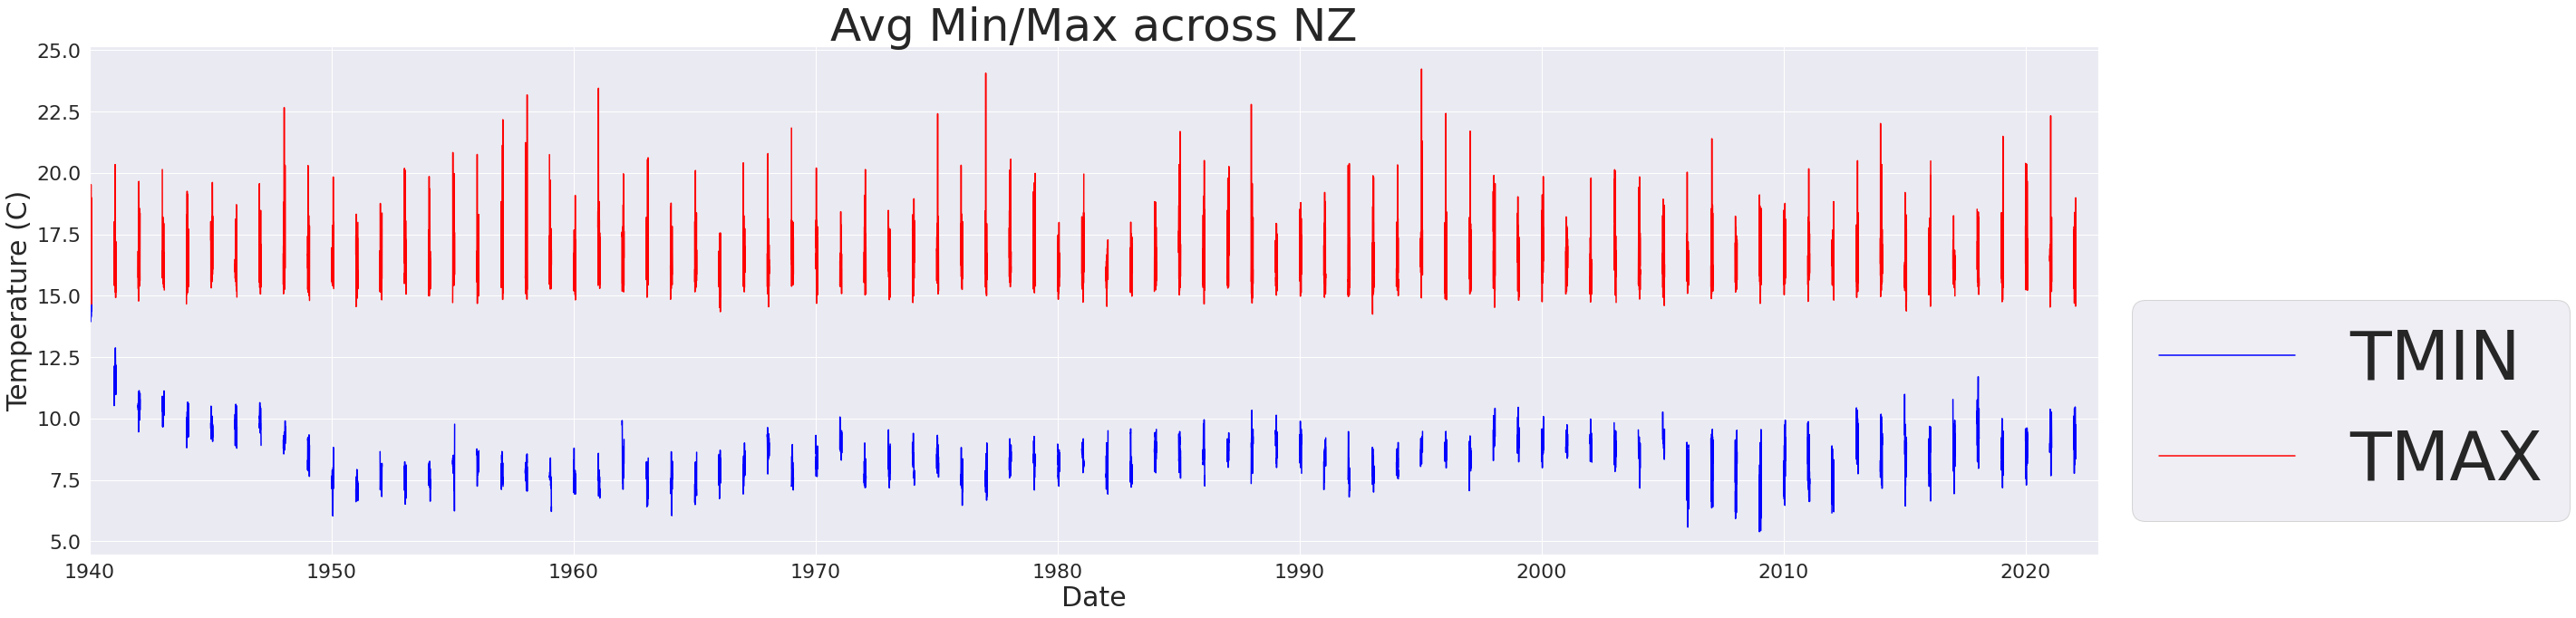

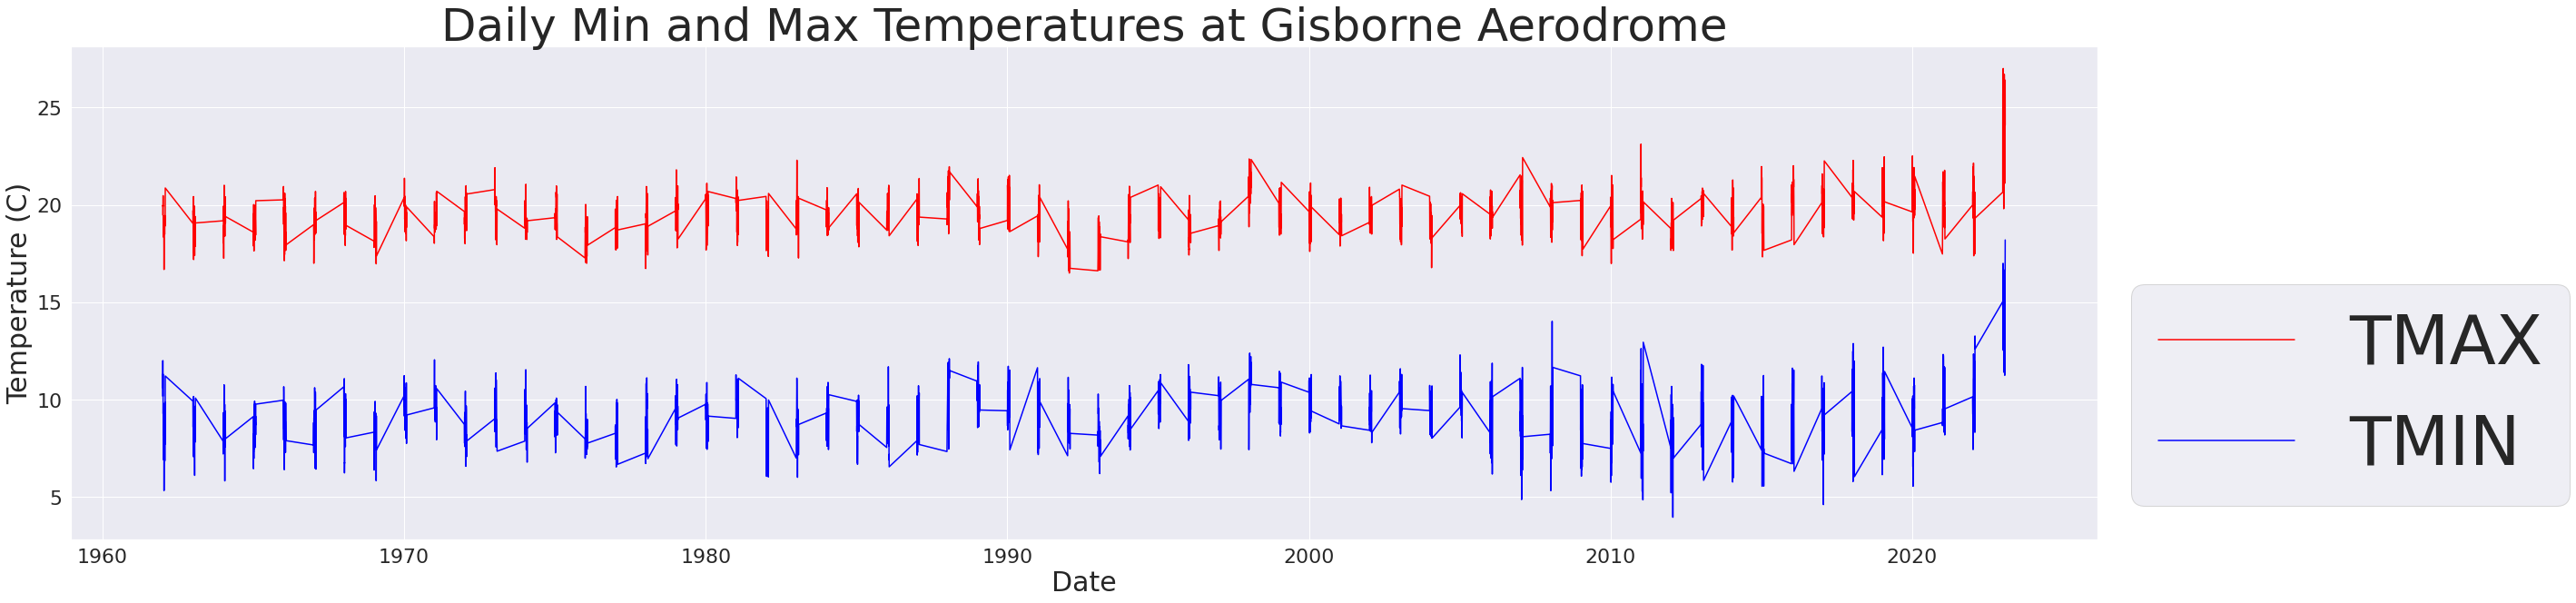

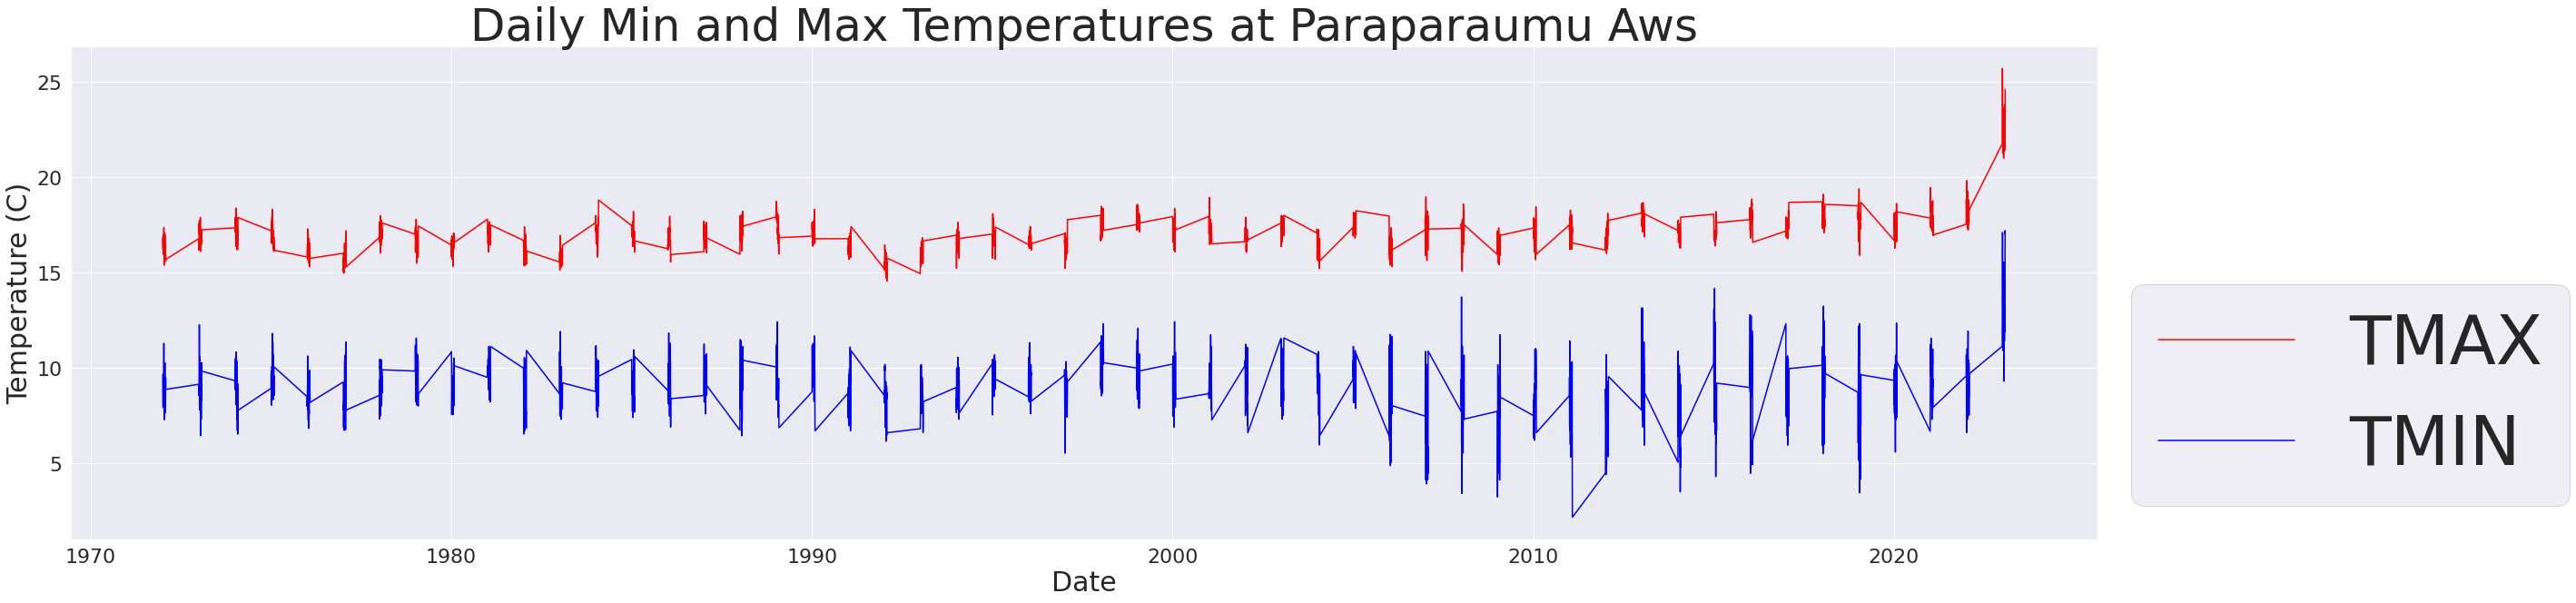

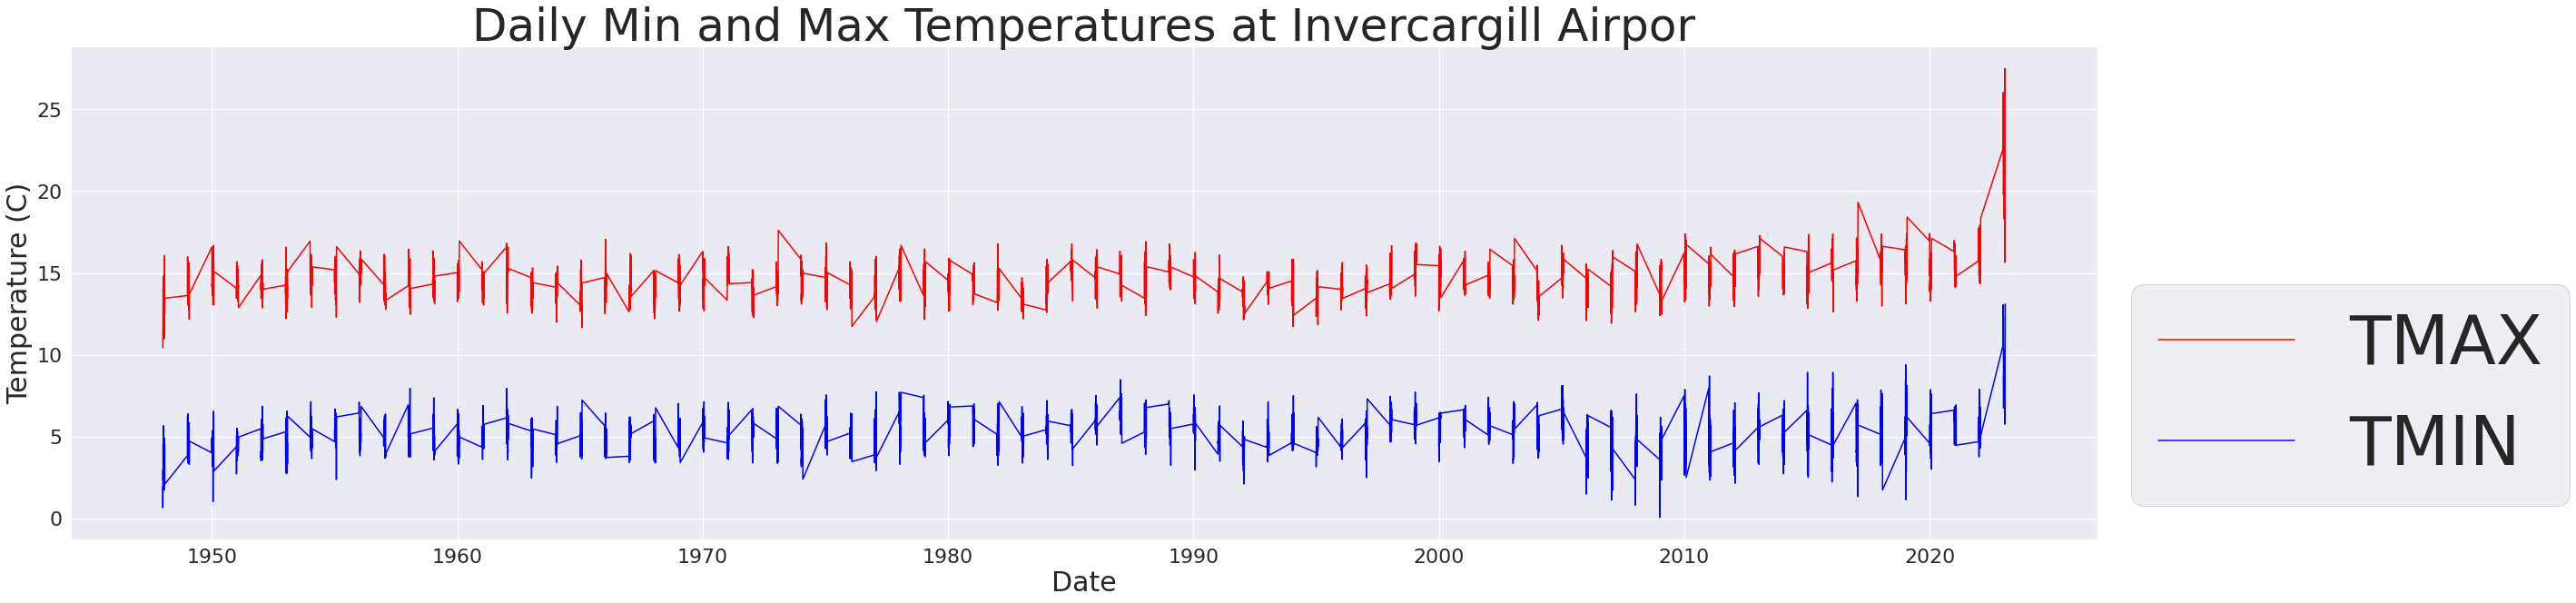

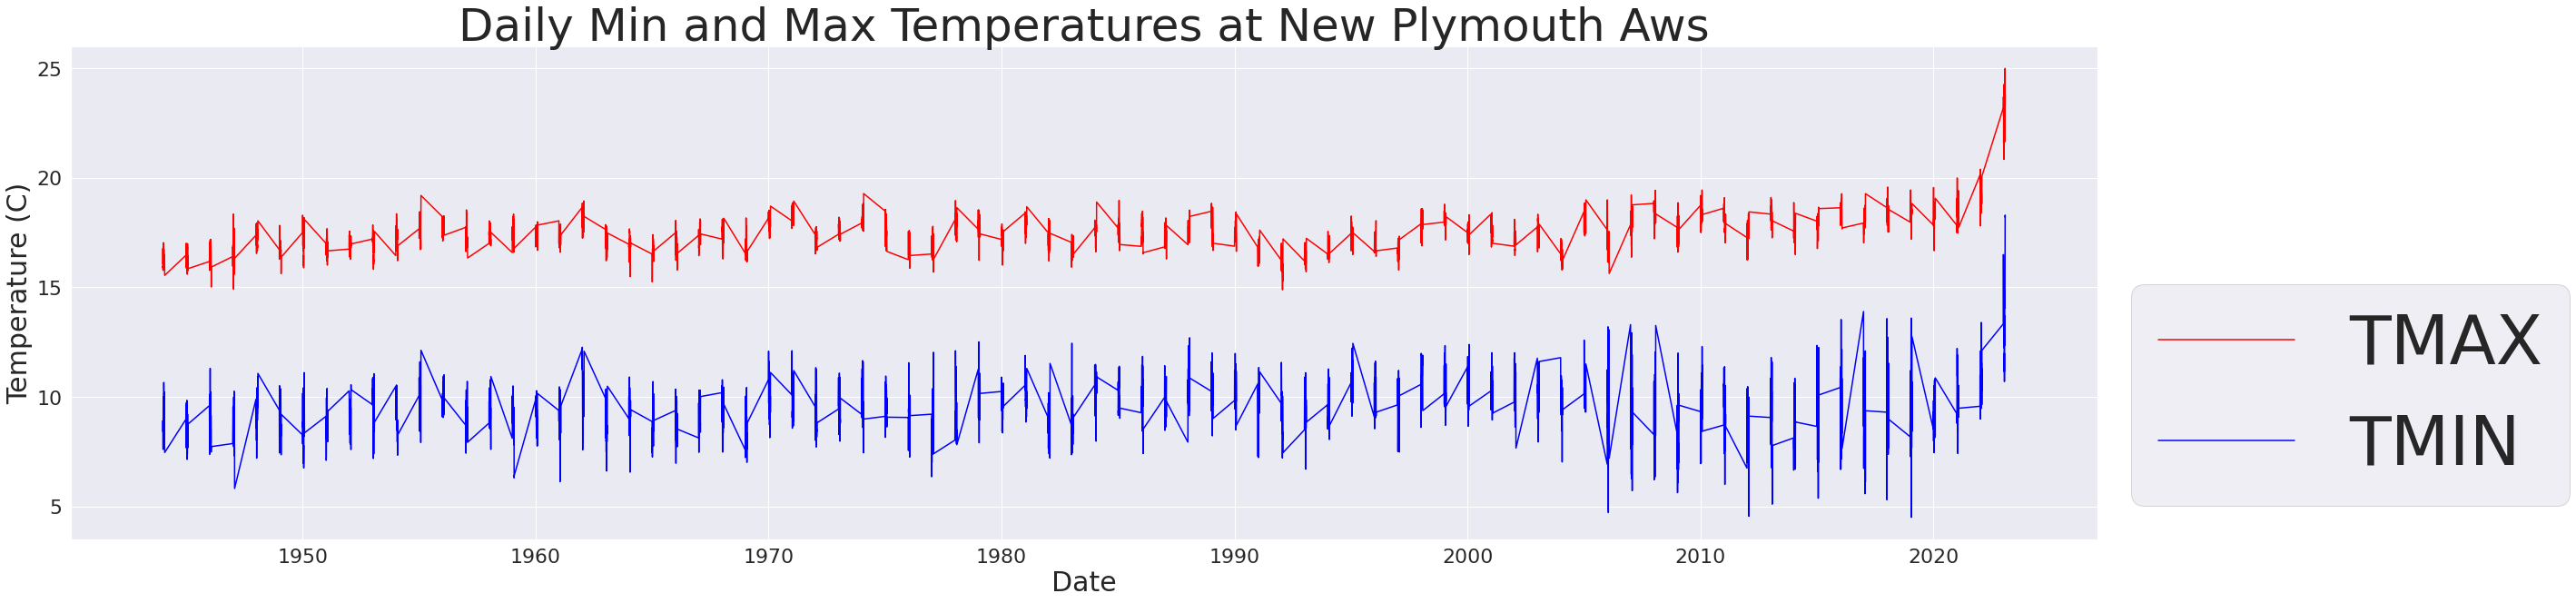

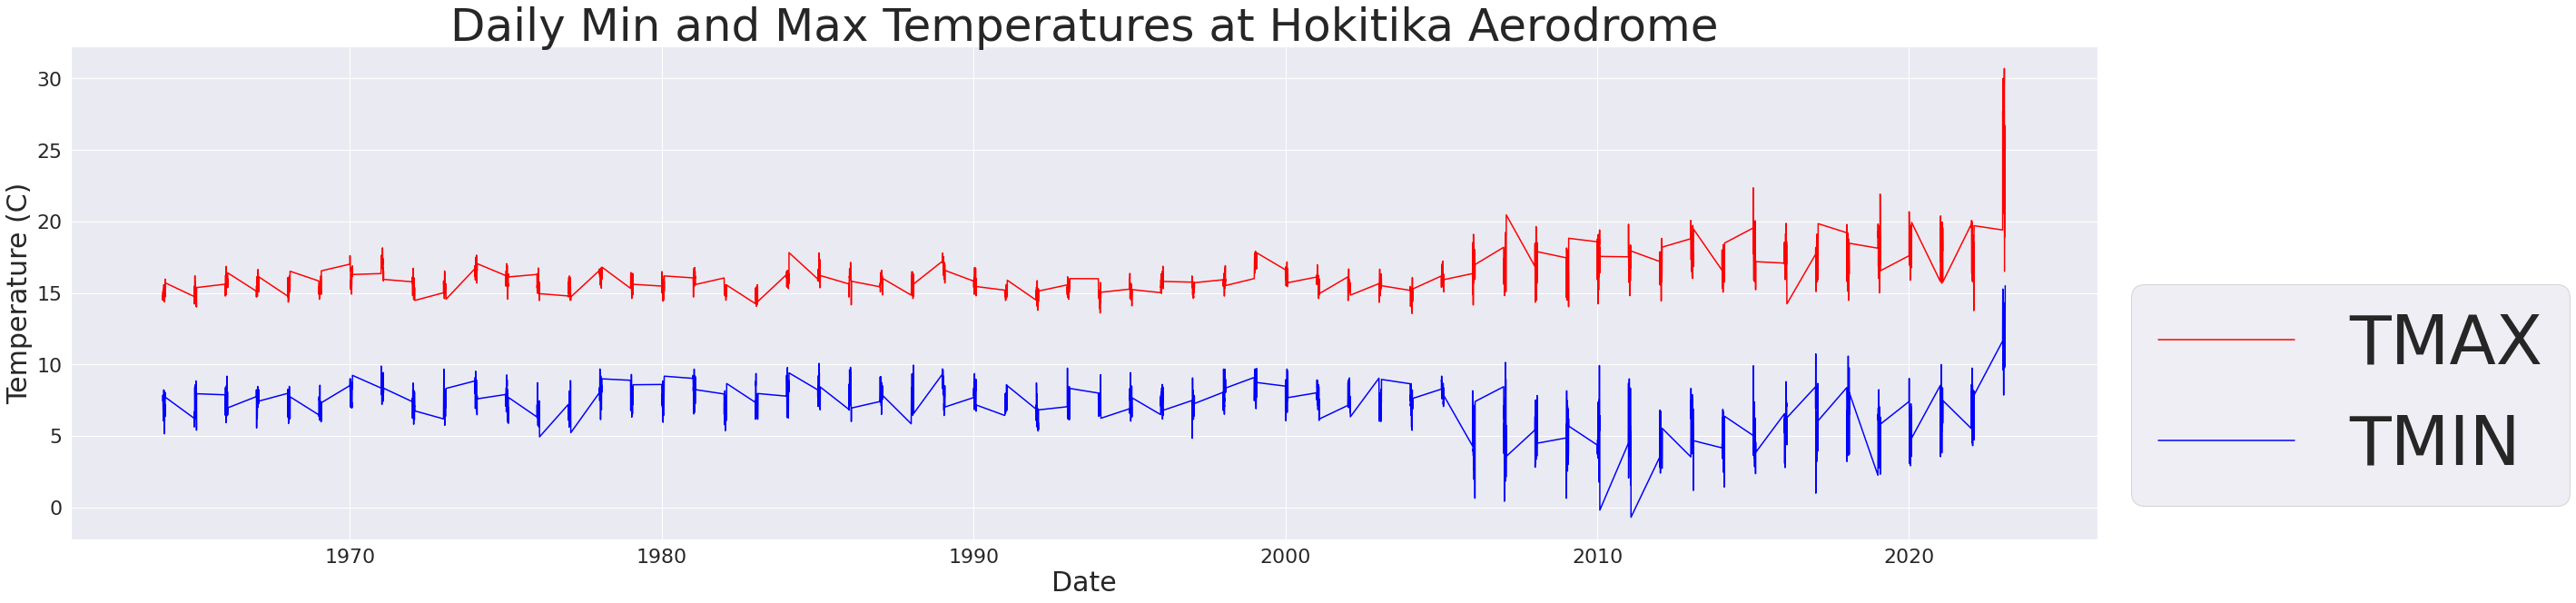

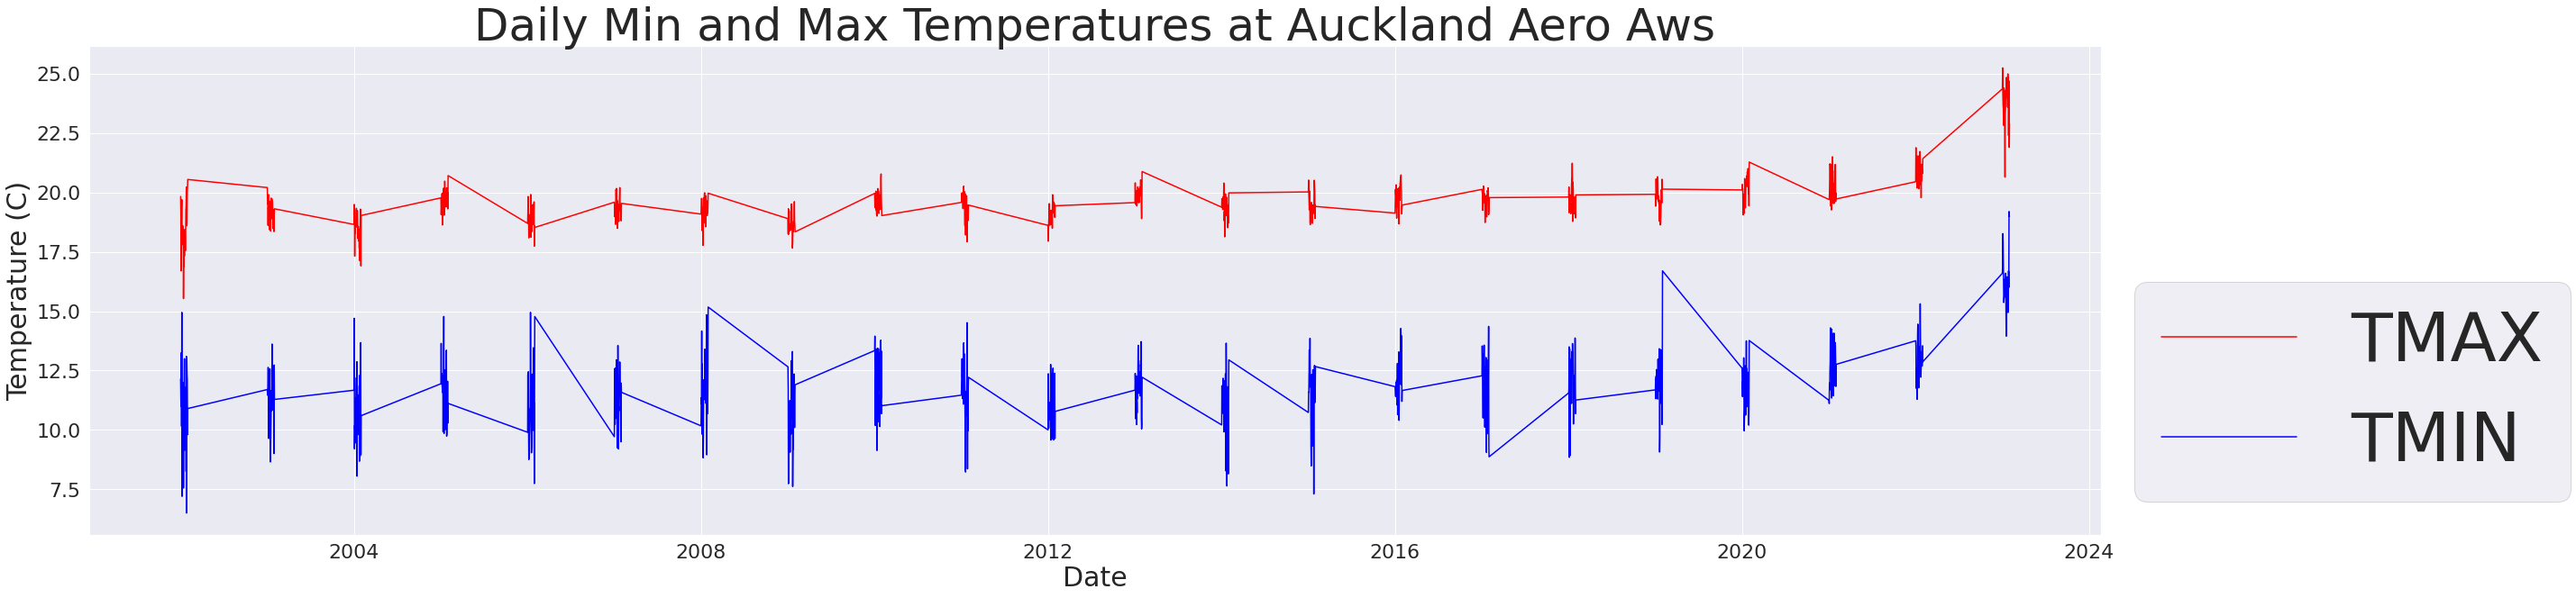

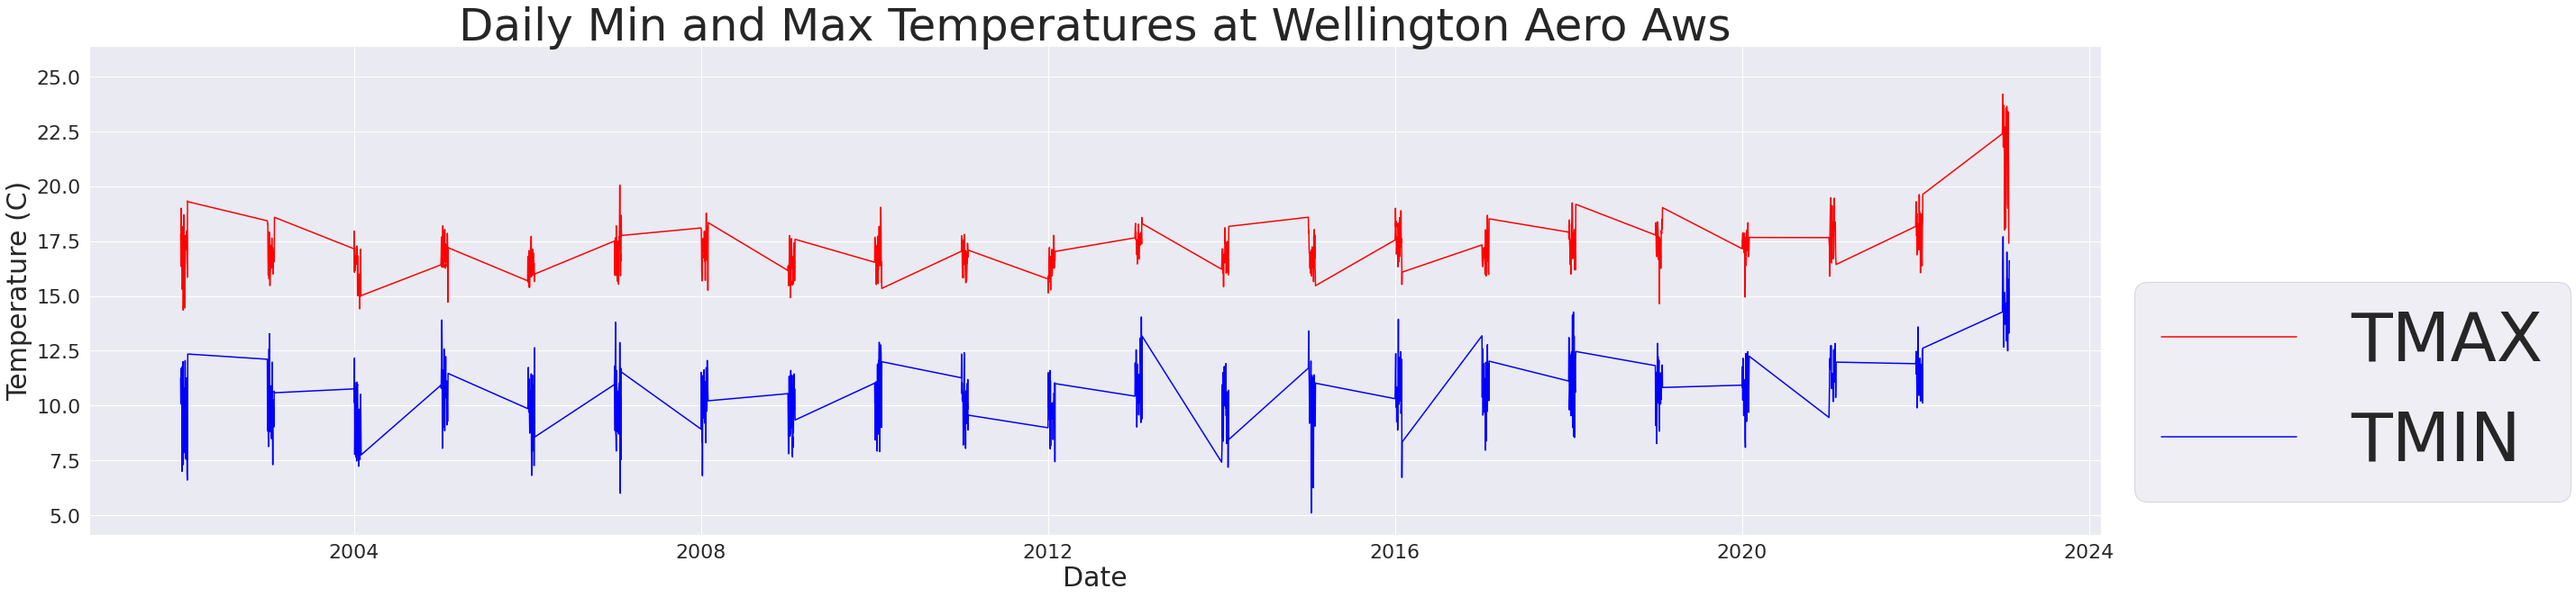

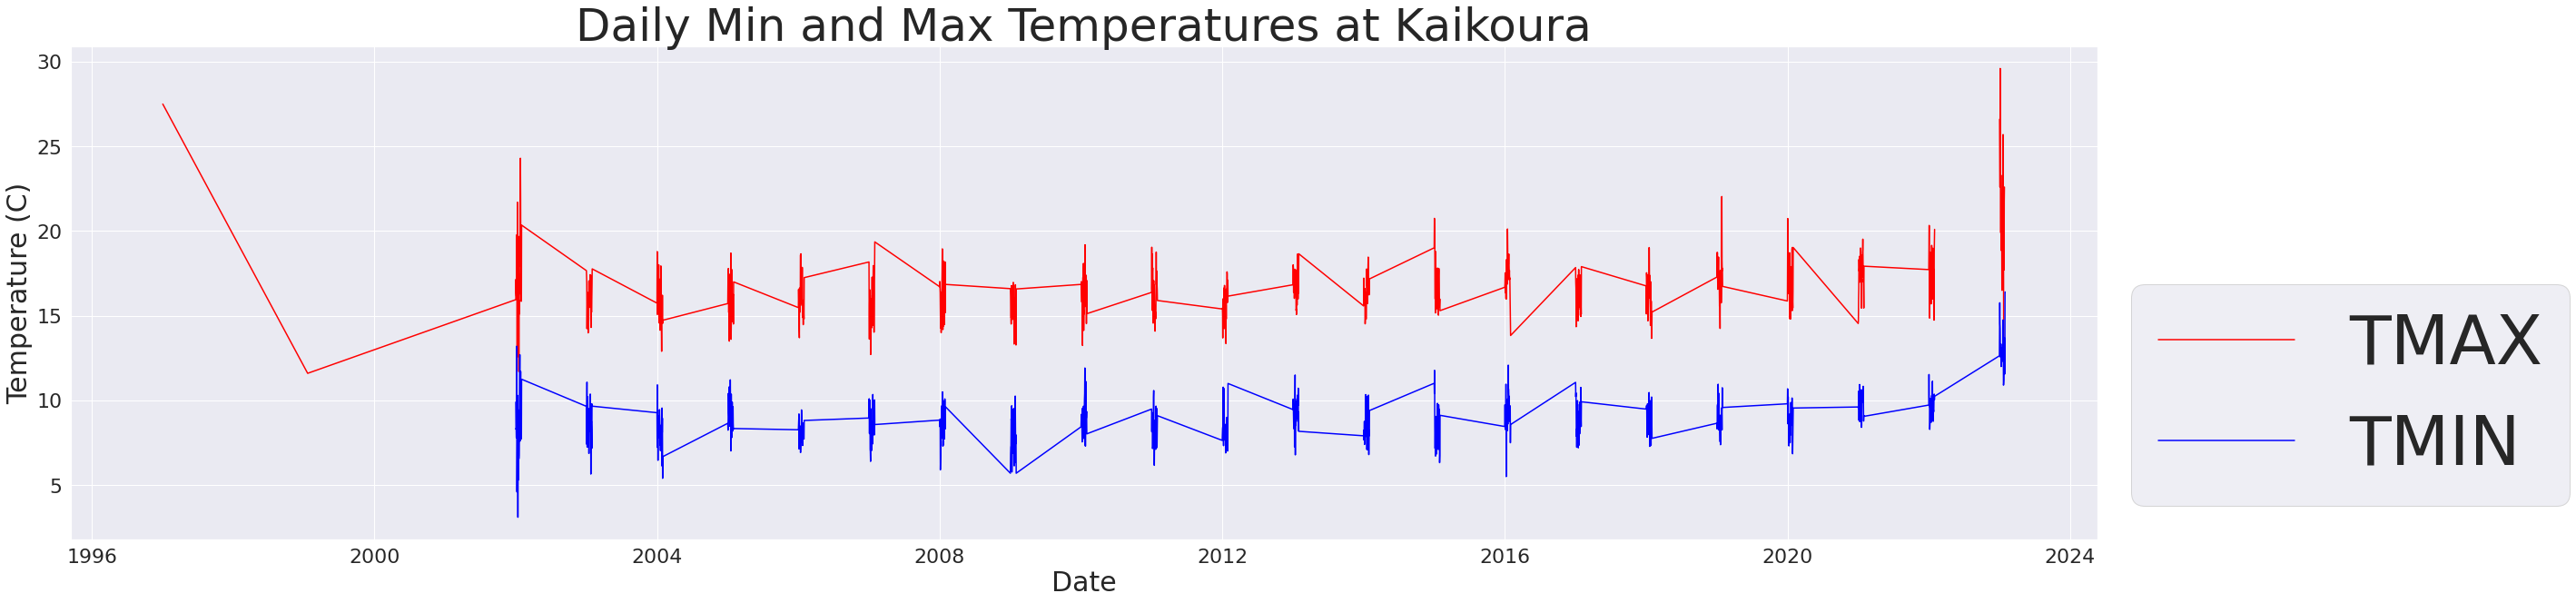

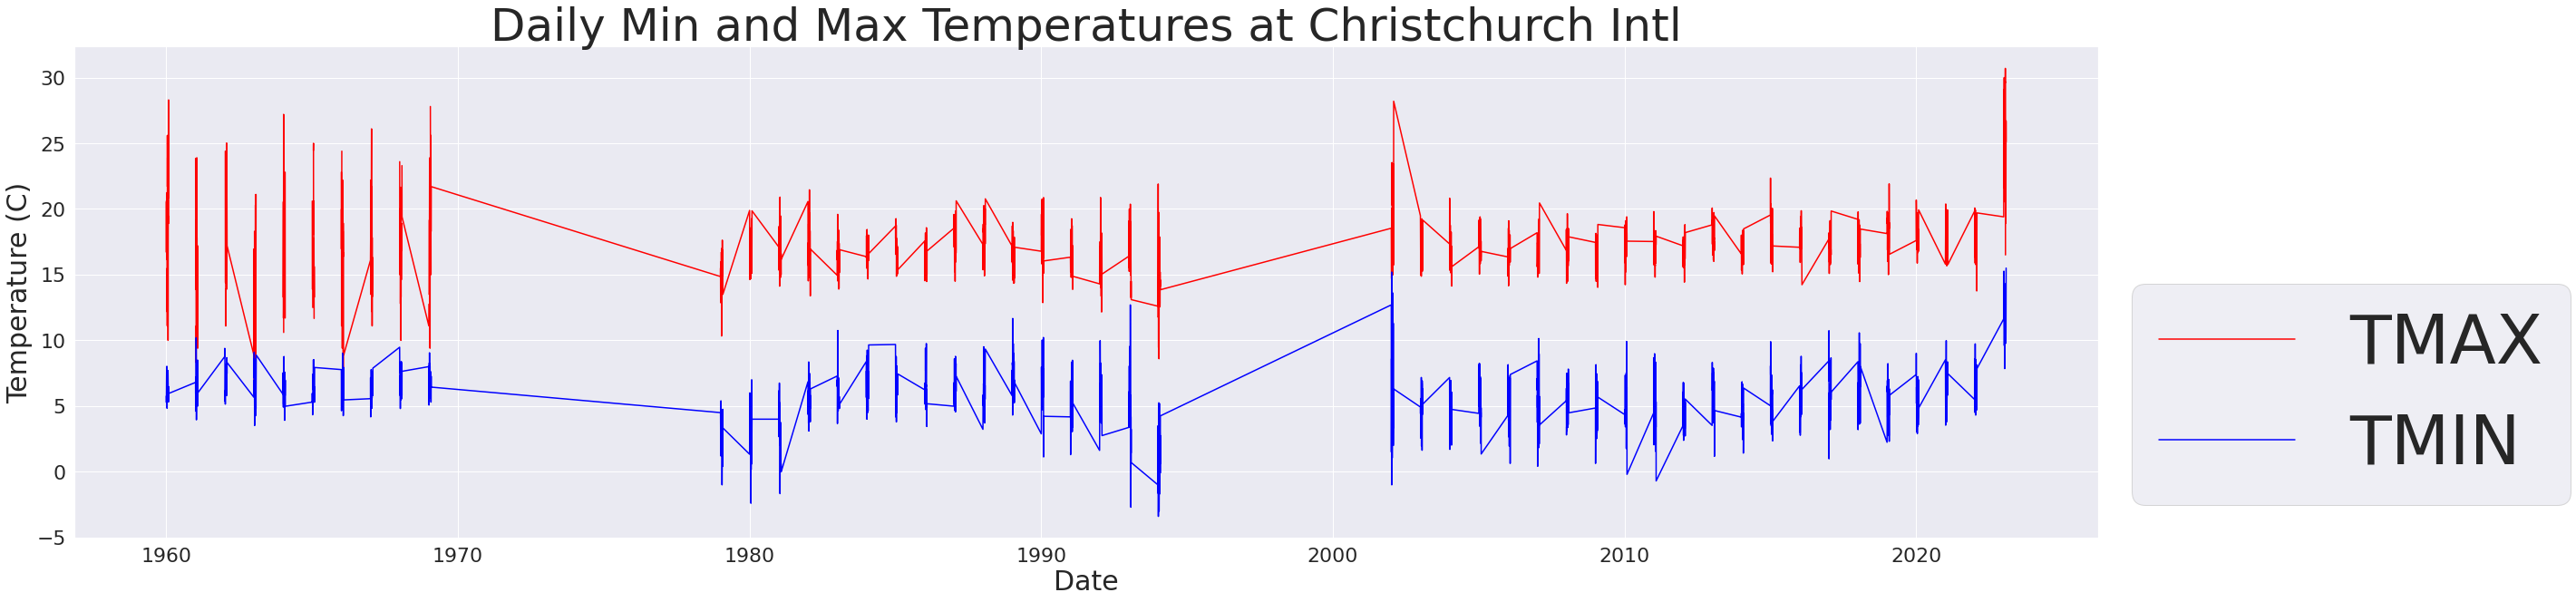

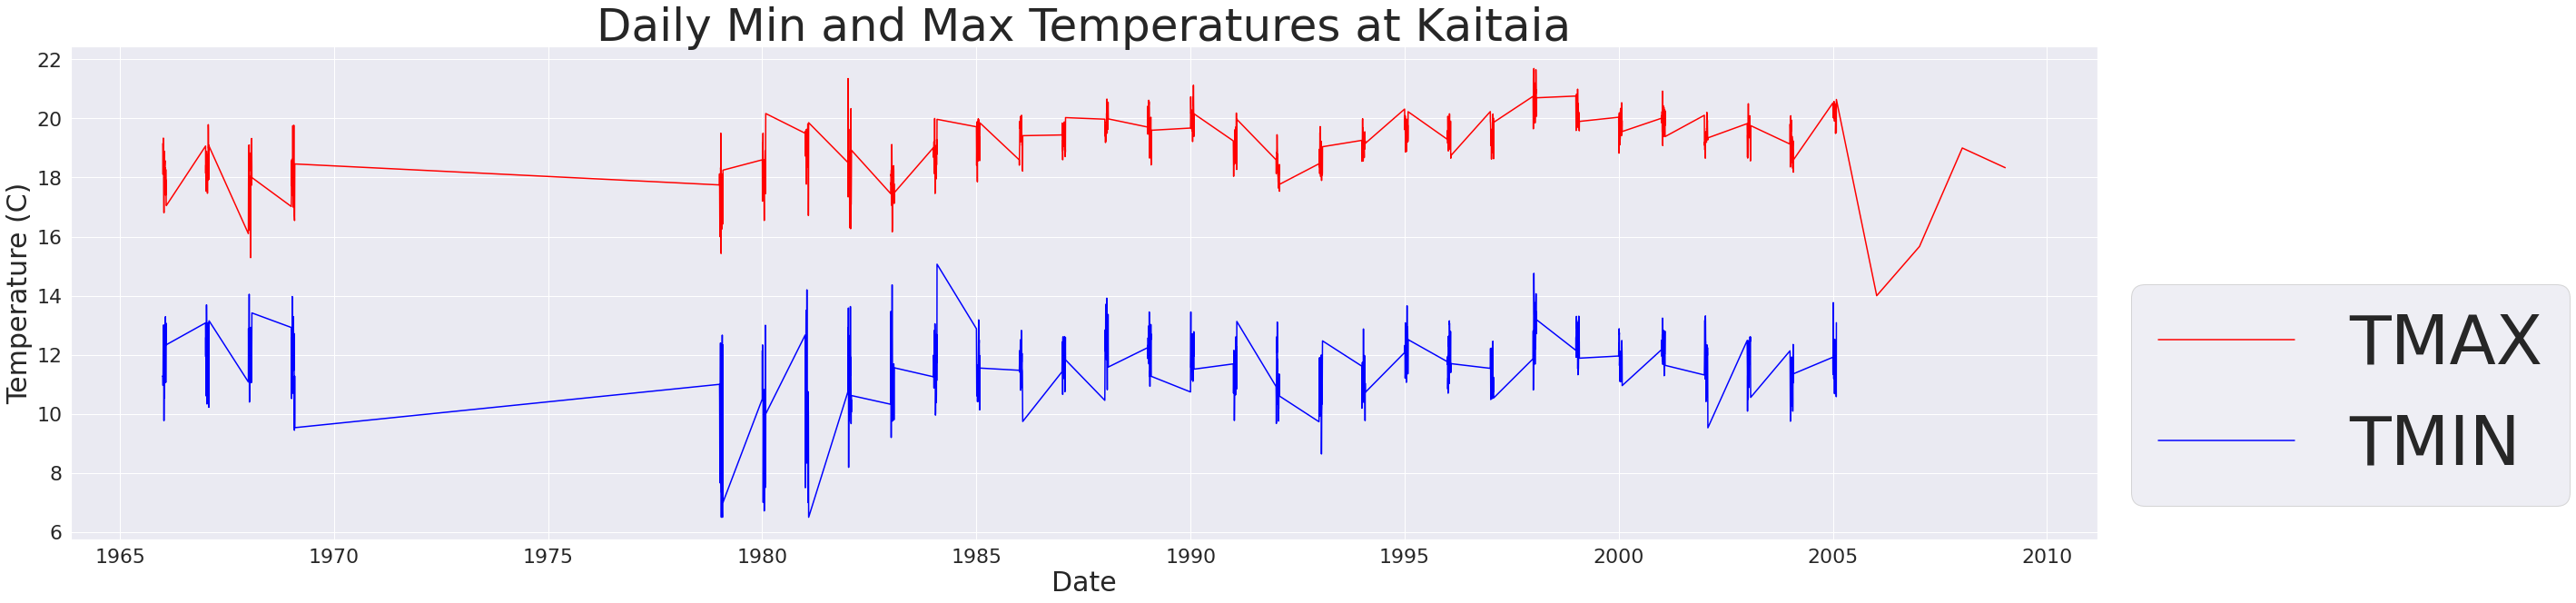

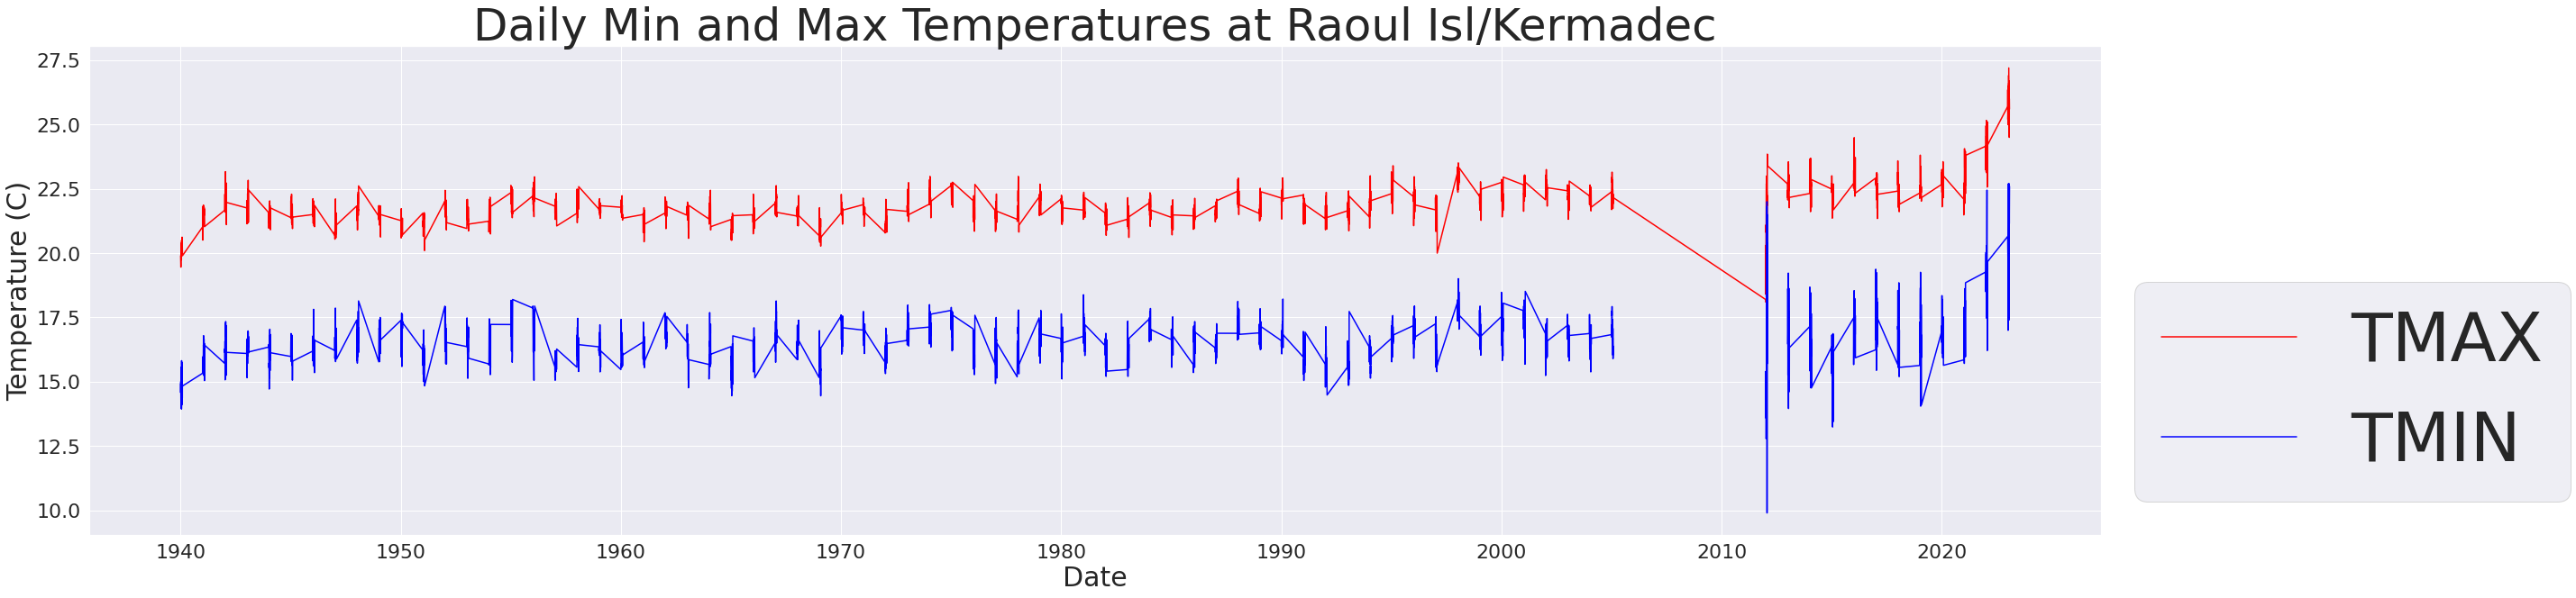

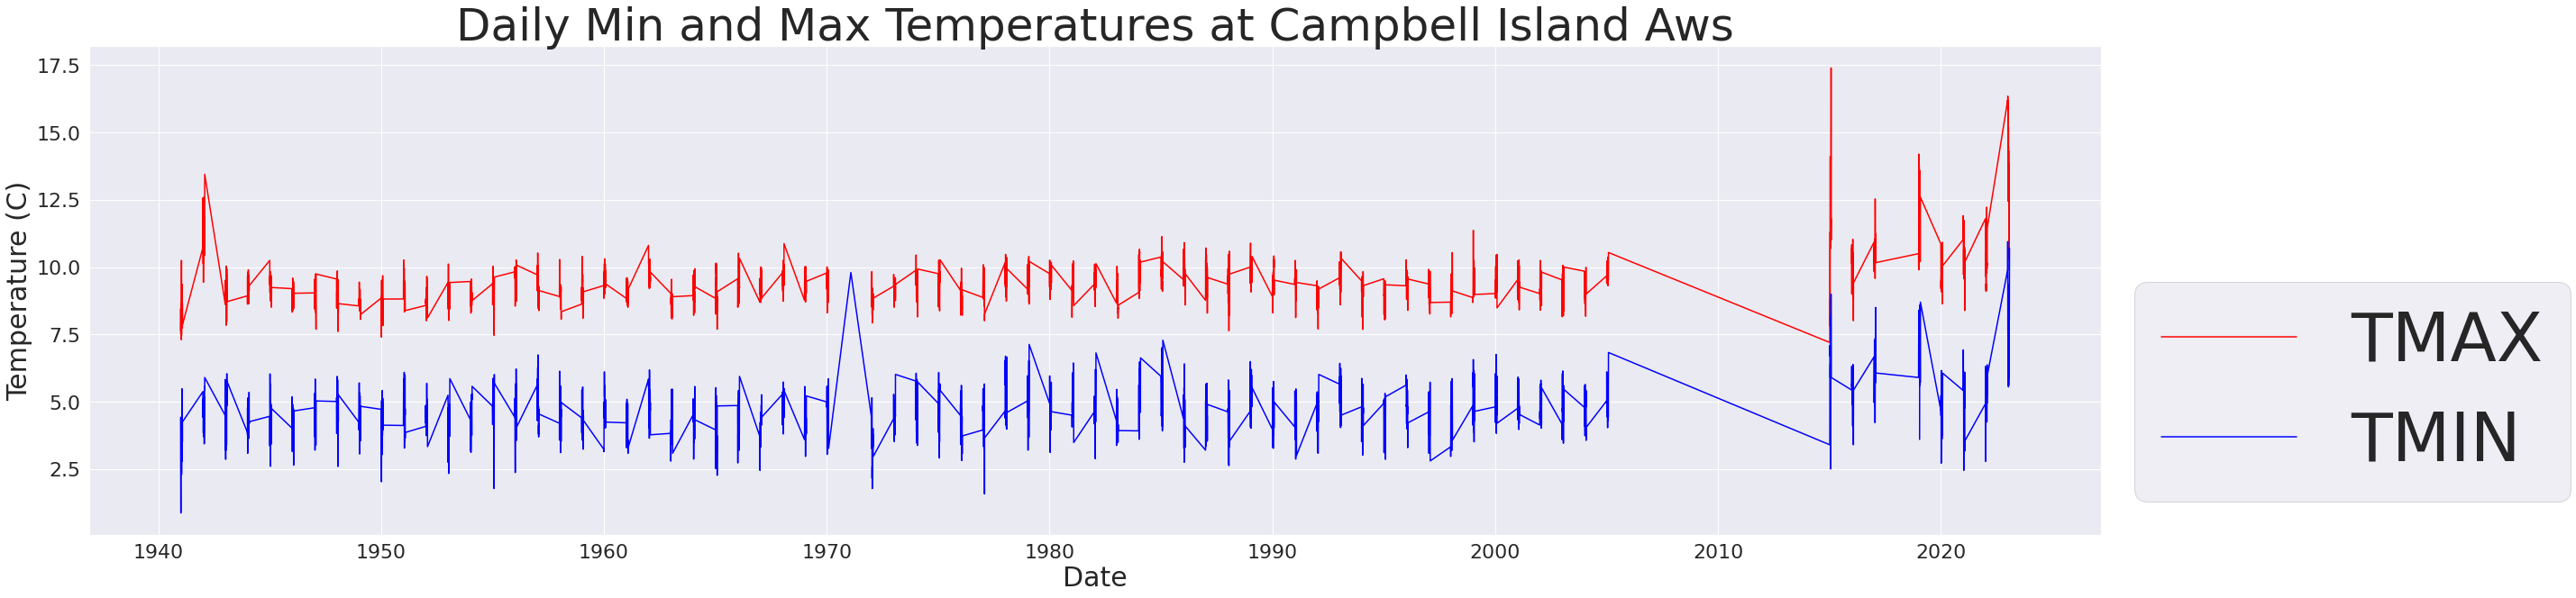

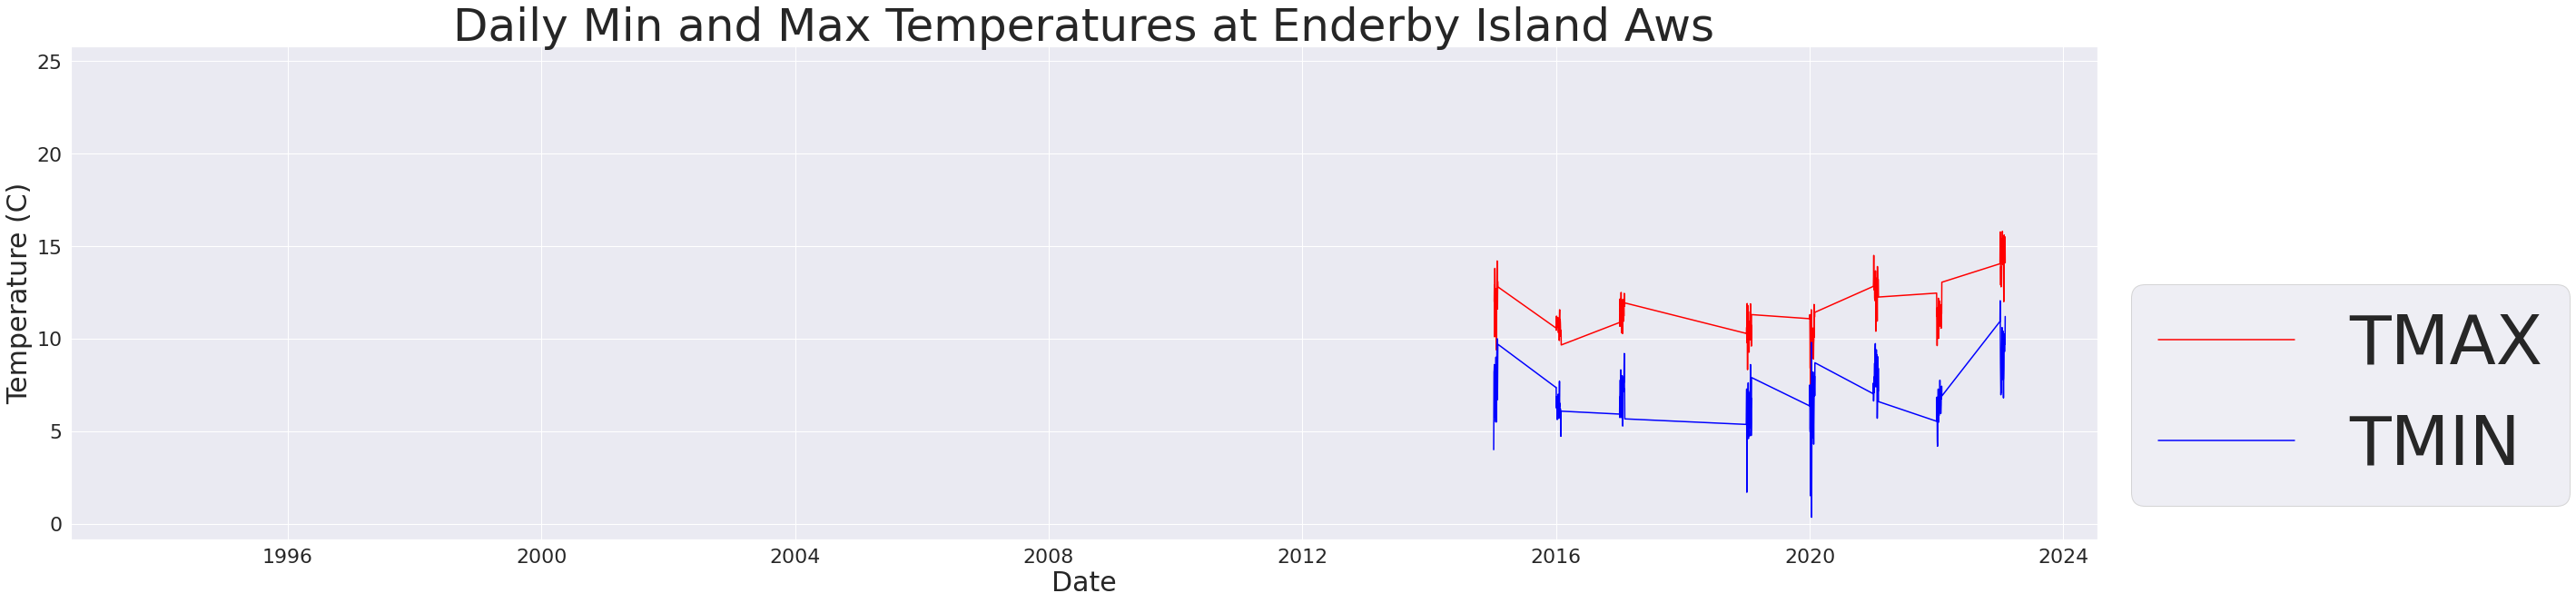

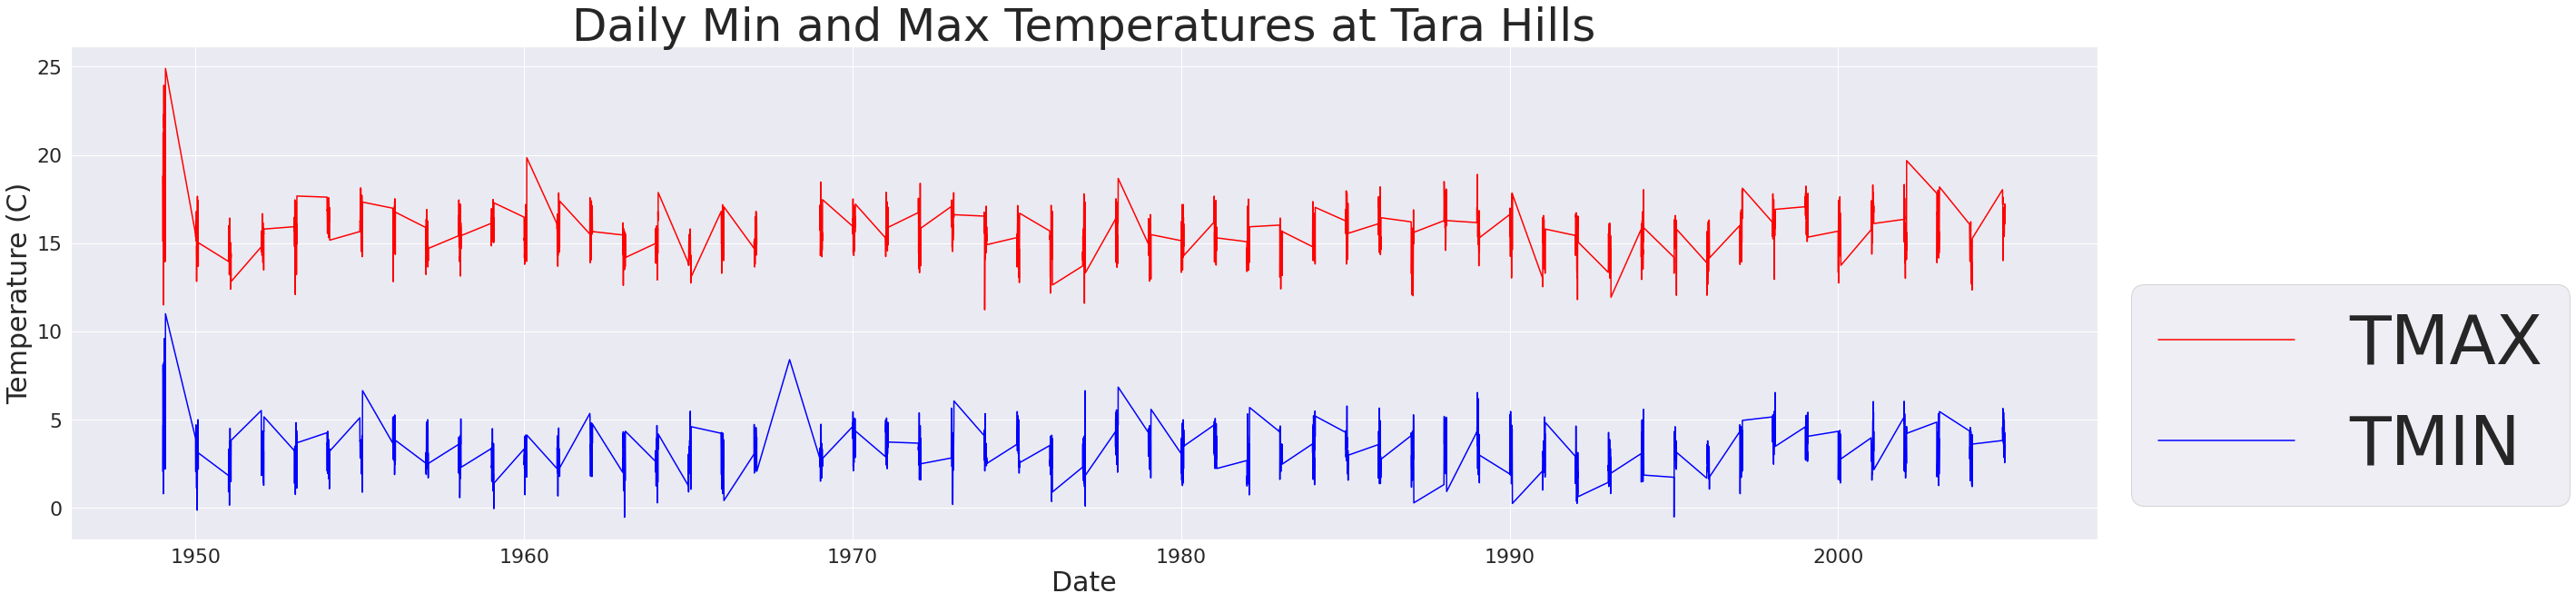

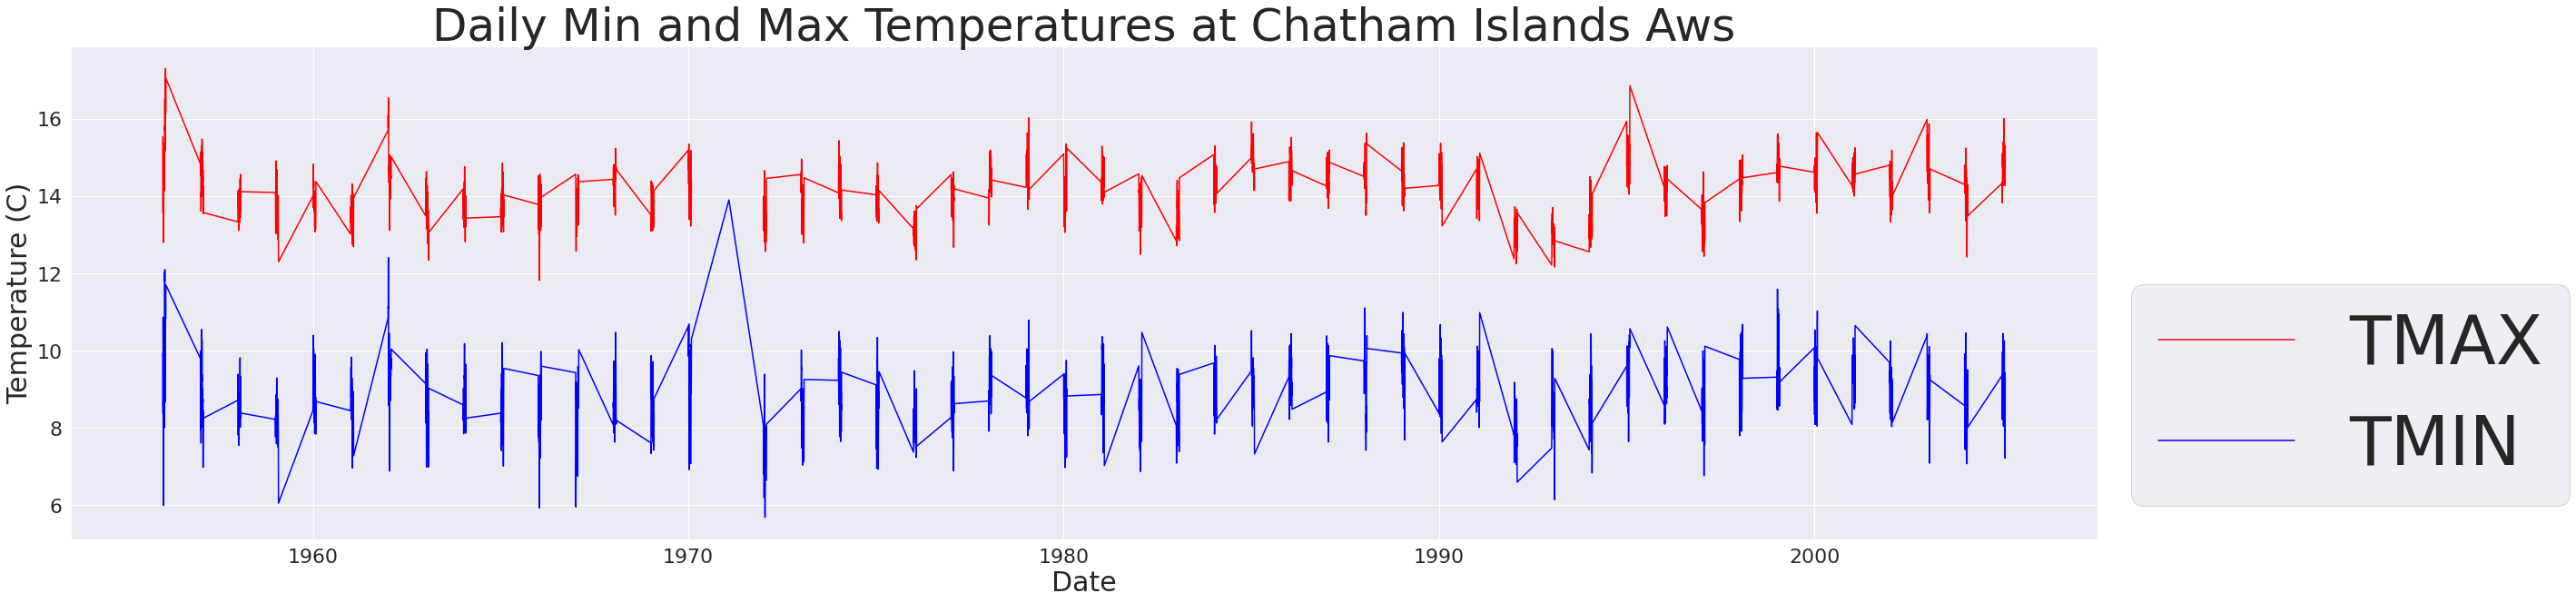

In [95]:
Individual_NZ_min_max_plots()

Q4 e

In [96]:
# Average Precipitation by country

Avg_prcpByCountry_allYears=(core_elements_daily
             .filter(F.col("Element")=="PRCP")
             .join(stations_broadcasted, on="Station_ID", how="left")
             .withColumn("Year", core_elements_daily.DATE.substr(1,4))
             .groupBy(["Country_Name","Year"])
             .agg(
                 F.avg(F.col("Element_Value")).alias("AvgRain_mm"))
             .sort([F.col("AvgRain_mm").desc()]))

# easier to save and reload 
# savefile("Yearly_Country_Rainfall_avg", Avg_prcpByCountry_allYears)

In [28]:
Avg_prcpByCountry_allYears.show(5)

+------------+----+------------------+
|Country_Code|Year|        AvgRain_mm|
+------------+----+------------------+
|          ZI|1966| 19.43456229250393|
|          ZI|1967| 20.80877350044763|
|          ZI|1968|14.718711494455201|
|          ZI|1959|  19.3493848857645|
|          ZI|2016|45.712460063897765|
+------------+----+------------------+
only showing top 5 rows



In [97]:
avg_schema=StructType([
    StructField("Country_Code", StringType(), True),
    StructField("Year", StringType(), True),
    StructField("AvgRain_mm", DoubleType(), True)])

Avg_prcpByCountry_allYears=(
    spark.read.format("com.databricks.spark.csv")
    .option("header", "False")
    .option("inferSchema", "False")
    .schema(avg_schema)
    .load("hdfs:///user/mda205/outputs/Yearly_Country_Rainfall_avg"))

In [98]:
code_conversion=pd.read_csv("isp_to_fips.csv") 
# csv i made from government isp and fips country codes to get it to match geopandas built in country codes
# i made the csv line up with what i need in excel..i know its hackey and hard coding but i was getting frusterated

code_schema=StructType([
    StructField("iso_a3", StringType(), True),
    StructField("Country_Code", StringType(), True)])

countryCodes_gdpFormat=spark.createDataFrame(code_conversion, schema=code_schema)

In [99]:
Prcp2022_noDups_gpdCodes_panda=(Avg_prcpByCountry_allYears
                         .filter(F.col("Year")=="2022")
                         .dropDuplicates()
                         .join(countryCodes_gdpFormat, on="Country_Code", how="left")
                         .drop("Country_Code")
                         .toPandas())


# importing built in world map from geopandas
world_gpd = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# merge/joining geopandas DF with 
world_rain=world_gpd.merge(Prcp2022_noDups_gpdCodes_panda, on="iso_a3", how="left")
# now geopandas world map with polygons and lat/lon abilities has the avg 
# rainfall joined to each country (unless n/a) based on country code

In [100]:
stations_pandas=(stations_broadcasted
                 .select(
                        F.col("Lat"), 
                        F.col("Lon"), 
                        F.col("Country_Code"))
                 .toPandas())

In [101]:
stations_gpd_Codes=(stations_broadcasted
                    .select(
                        F.col("Lat"), 
                        F.col("Lon"), 
                        F.col("Country_Code"))
                    .join(countryCodes_gdpFormat, on="Country_Code", how="left")
                    .toPandas())

world_stations=stations_gpd_Codes.merge(world_gpd, on="iso_a3", how="left")
worldStations_gpd=(gpd.GeoDataFrame(
    world_stations, 
    geometry=gpd.points_from_xy(world_stations.Lon, world_stations.Lat)))

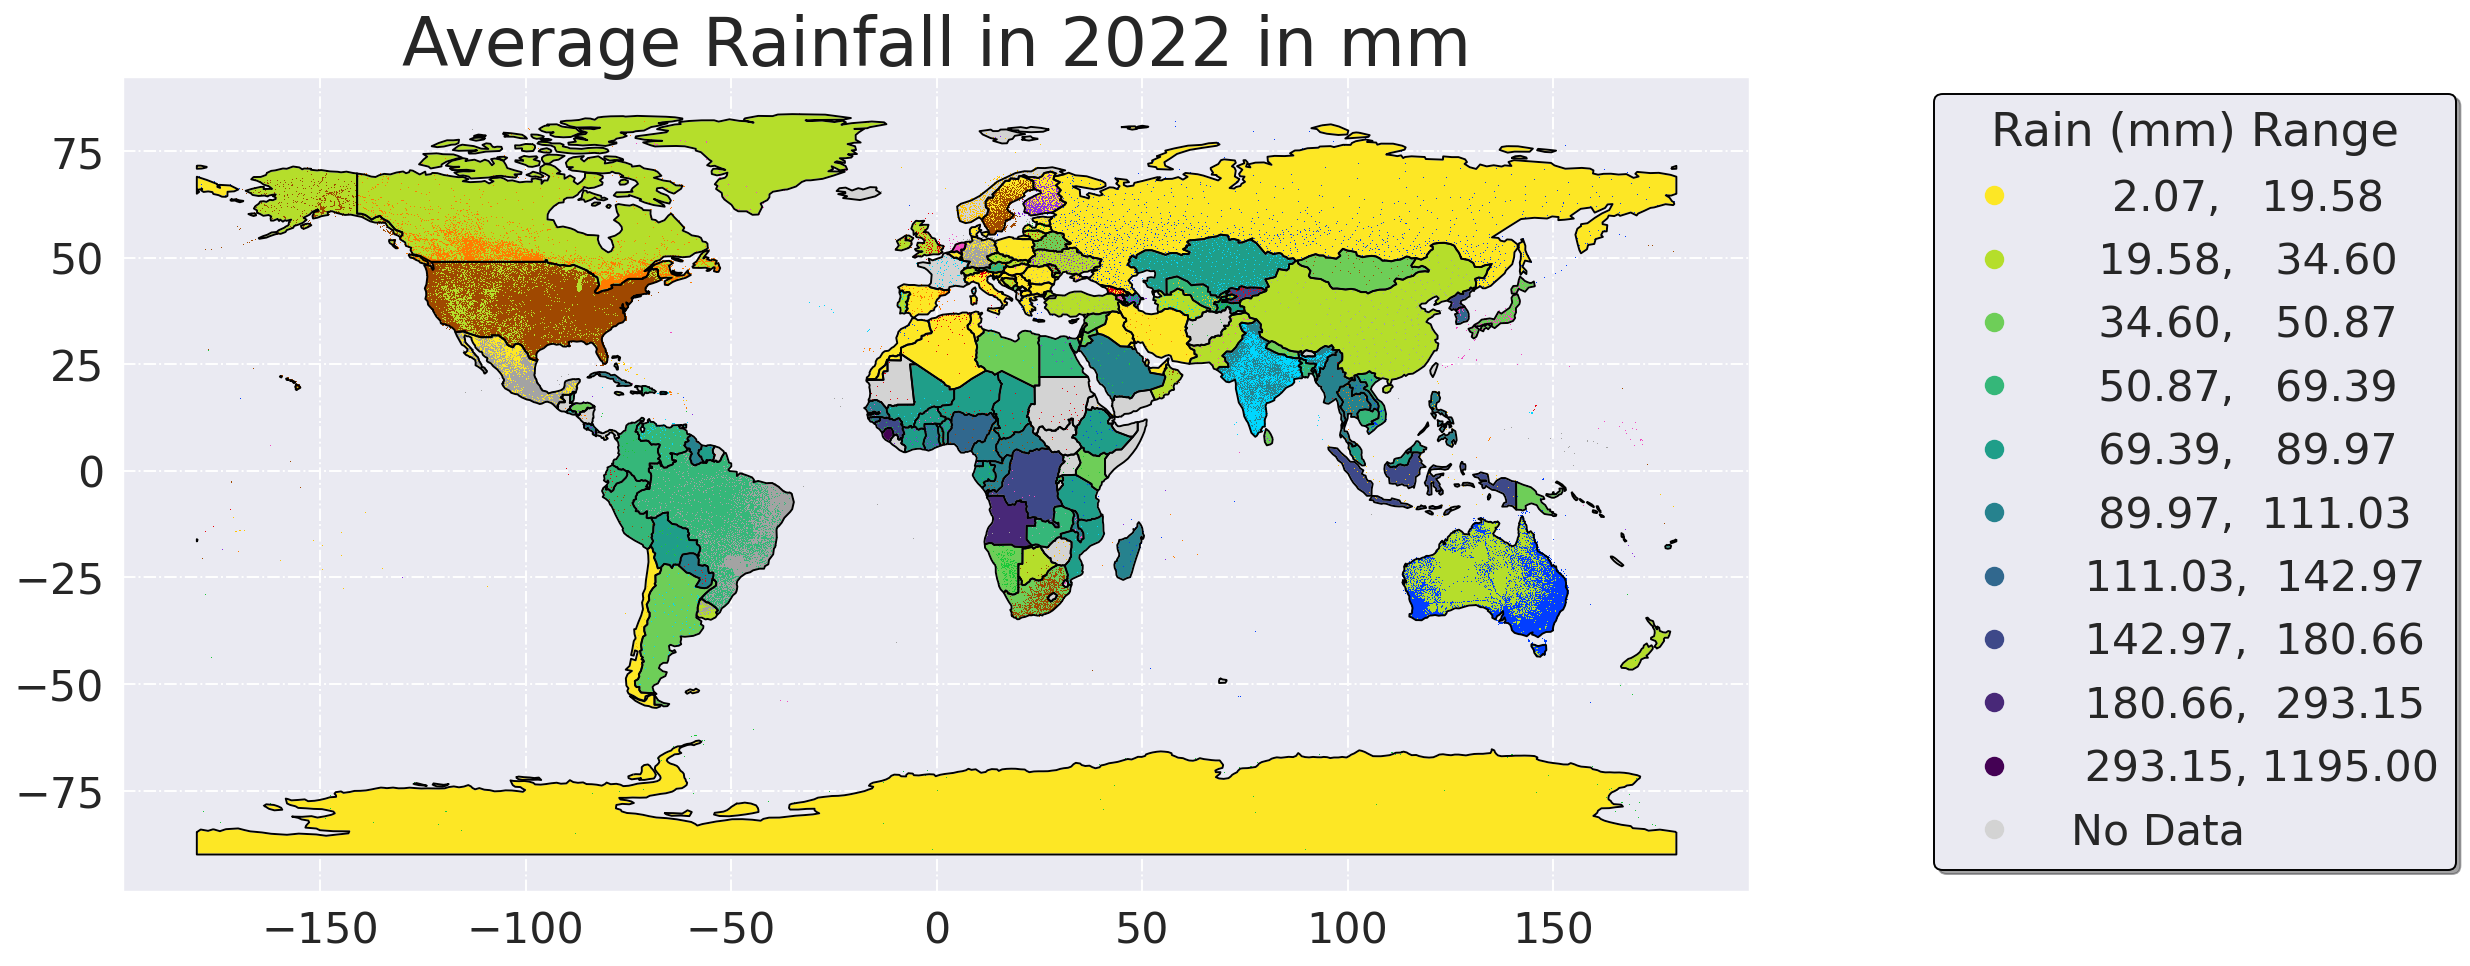

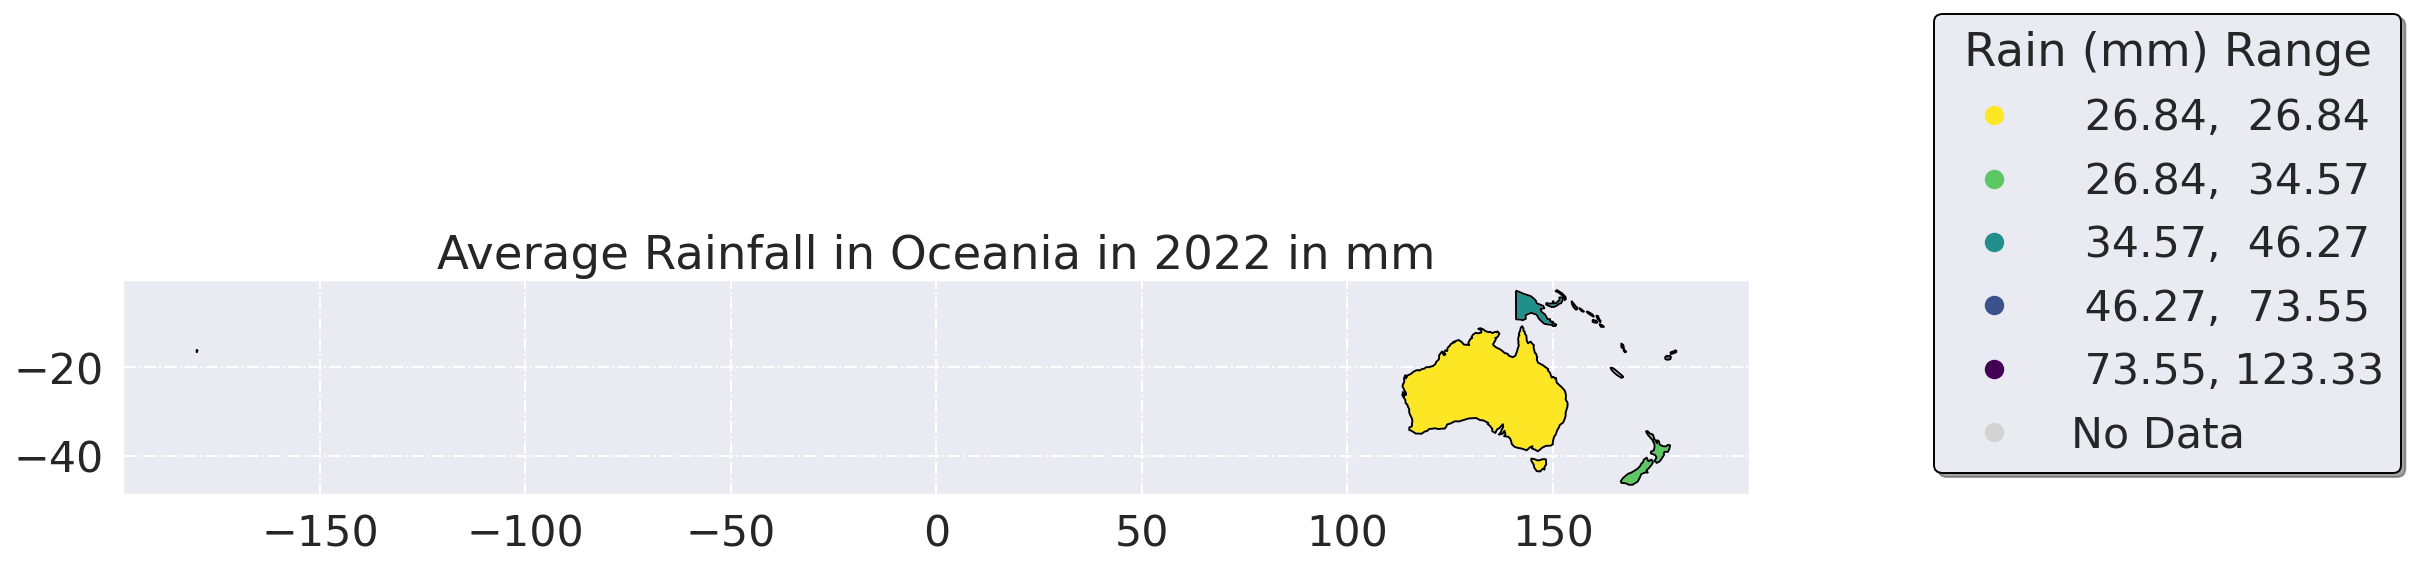

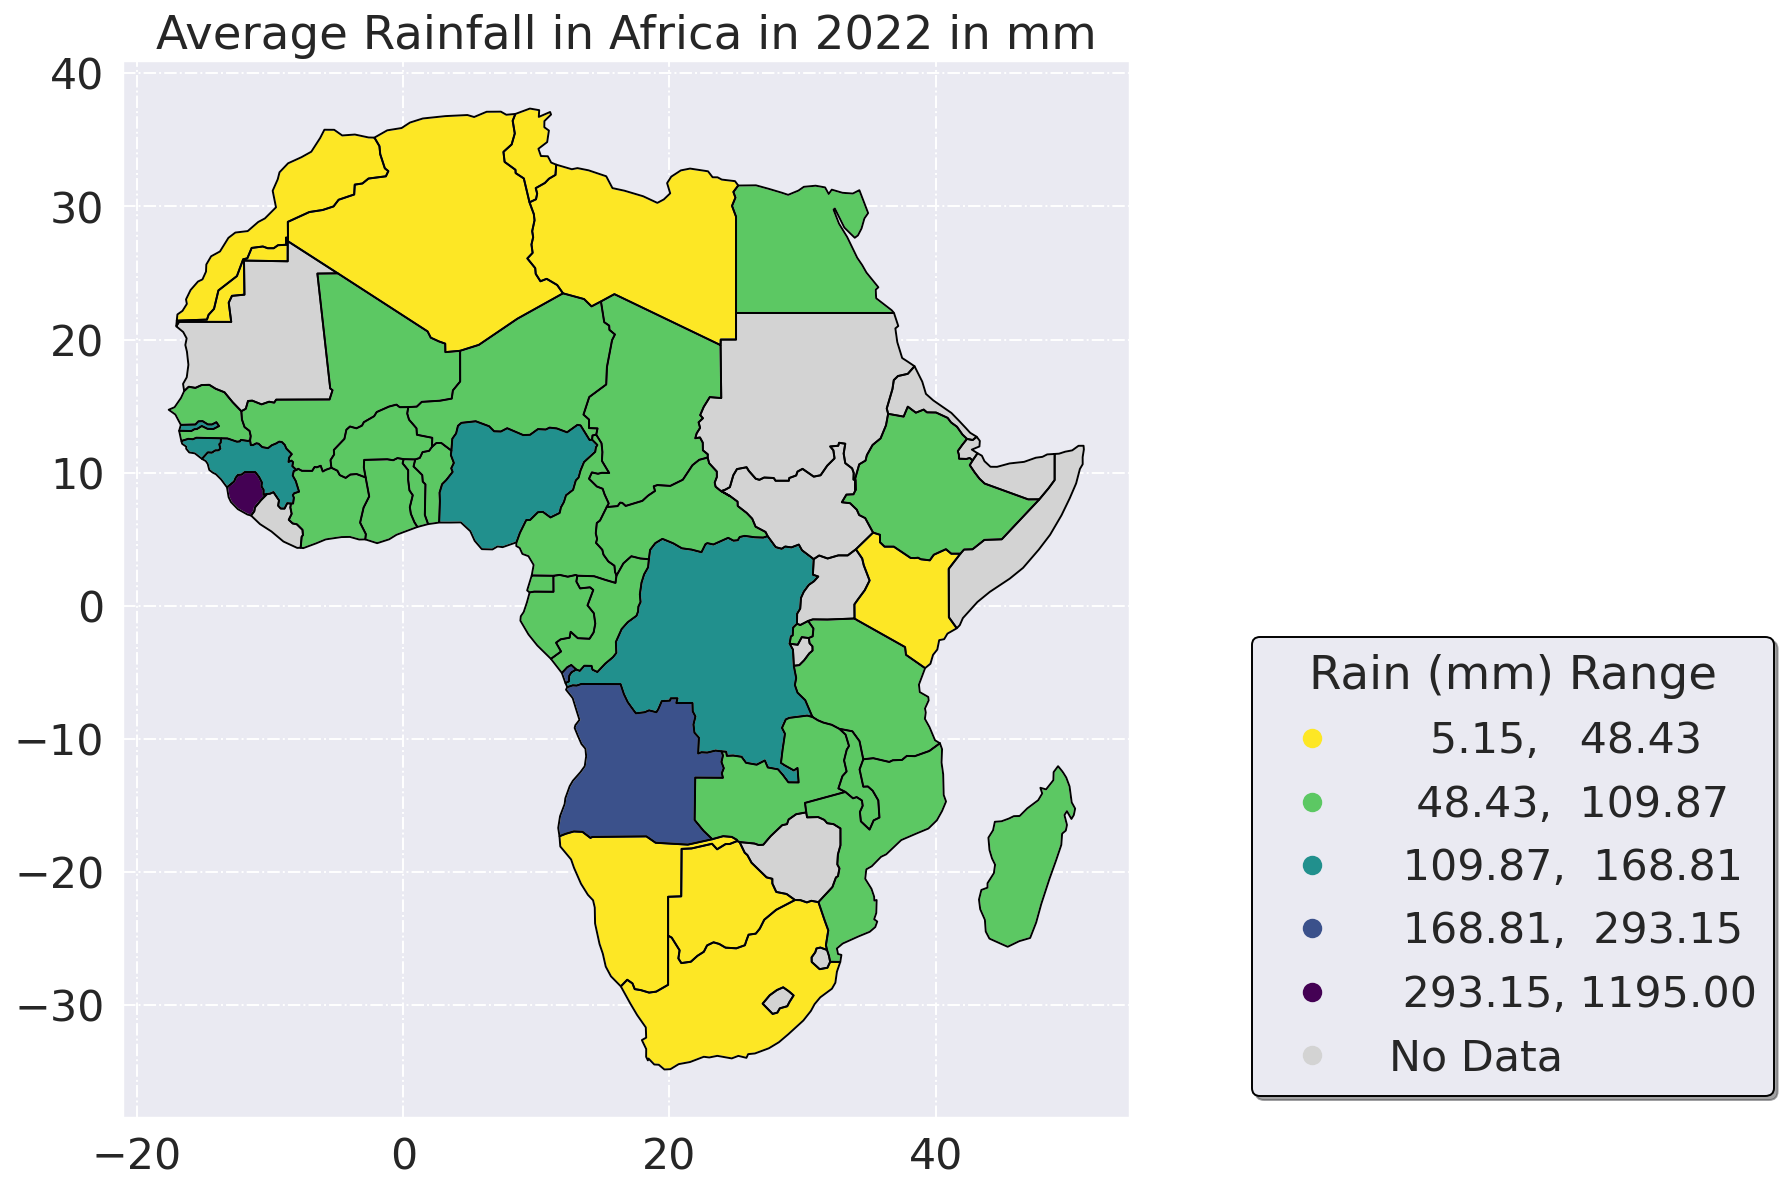

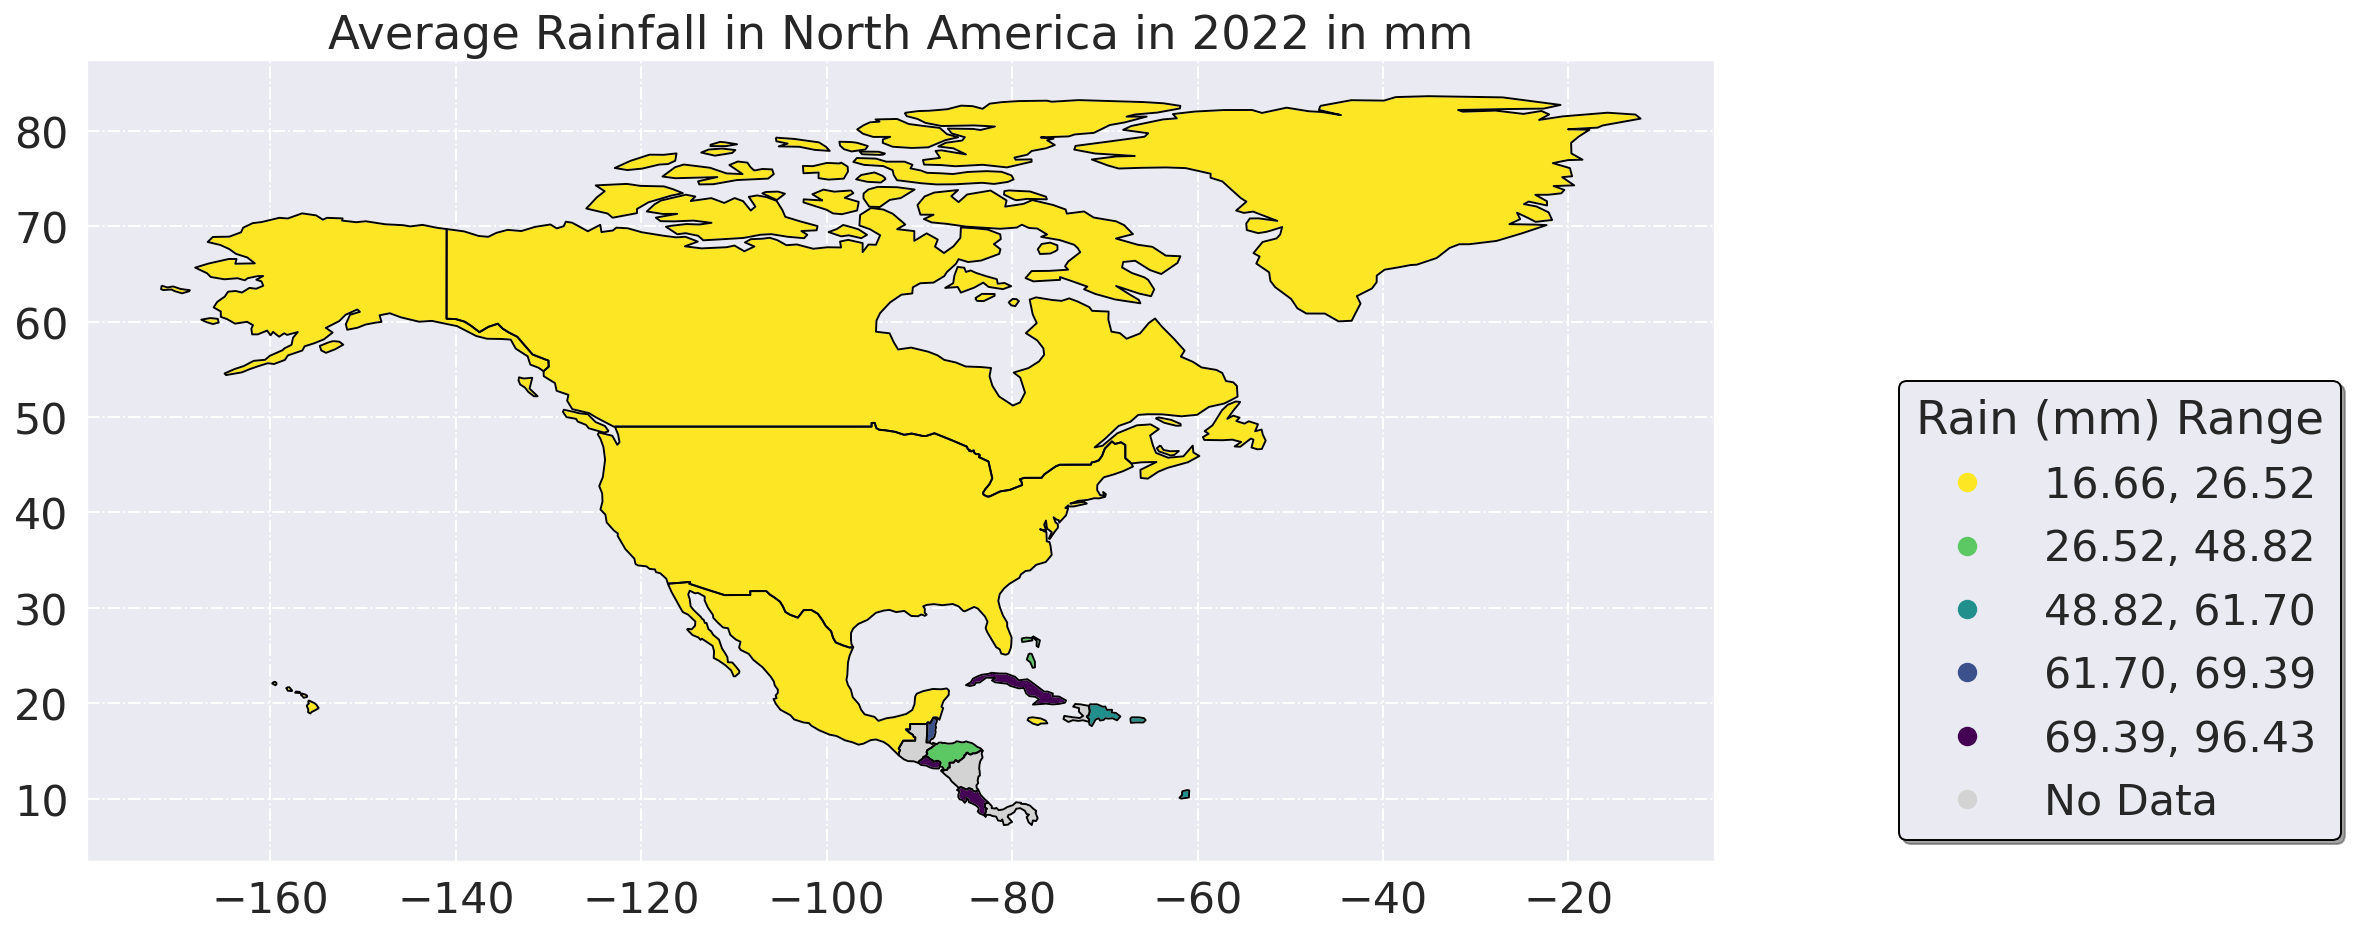

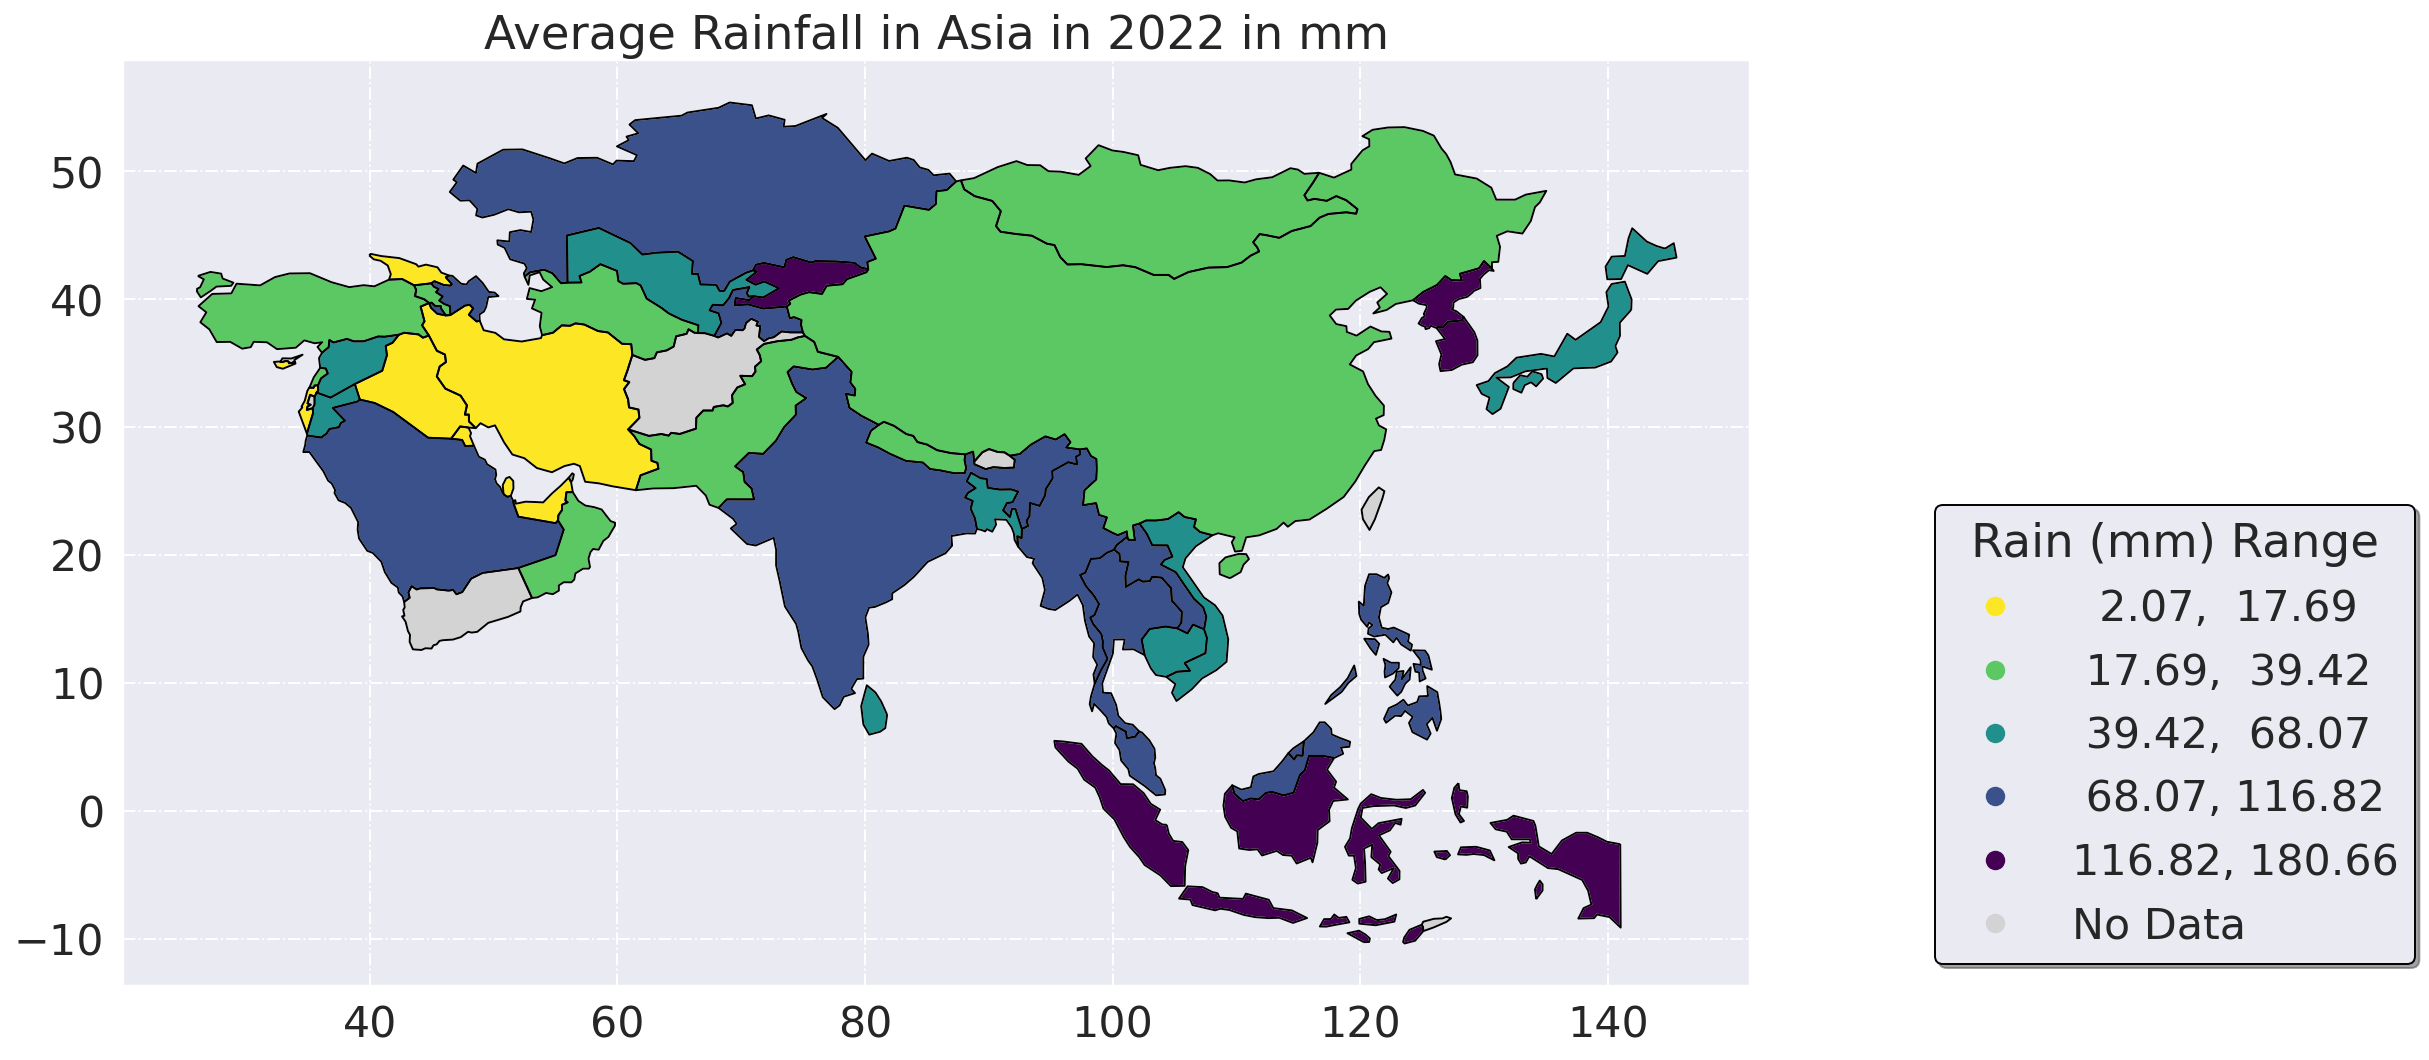

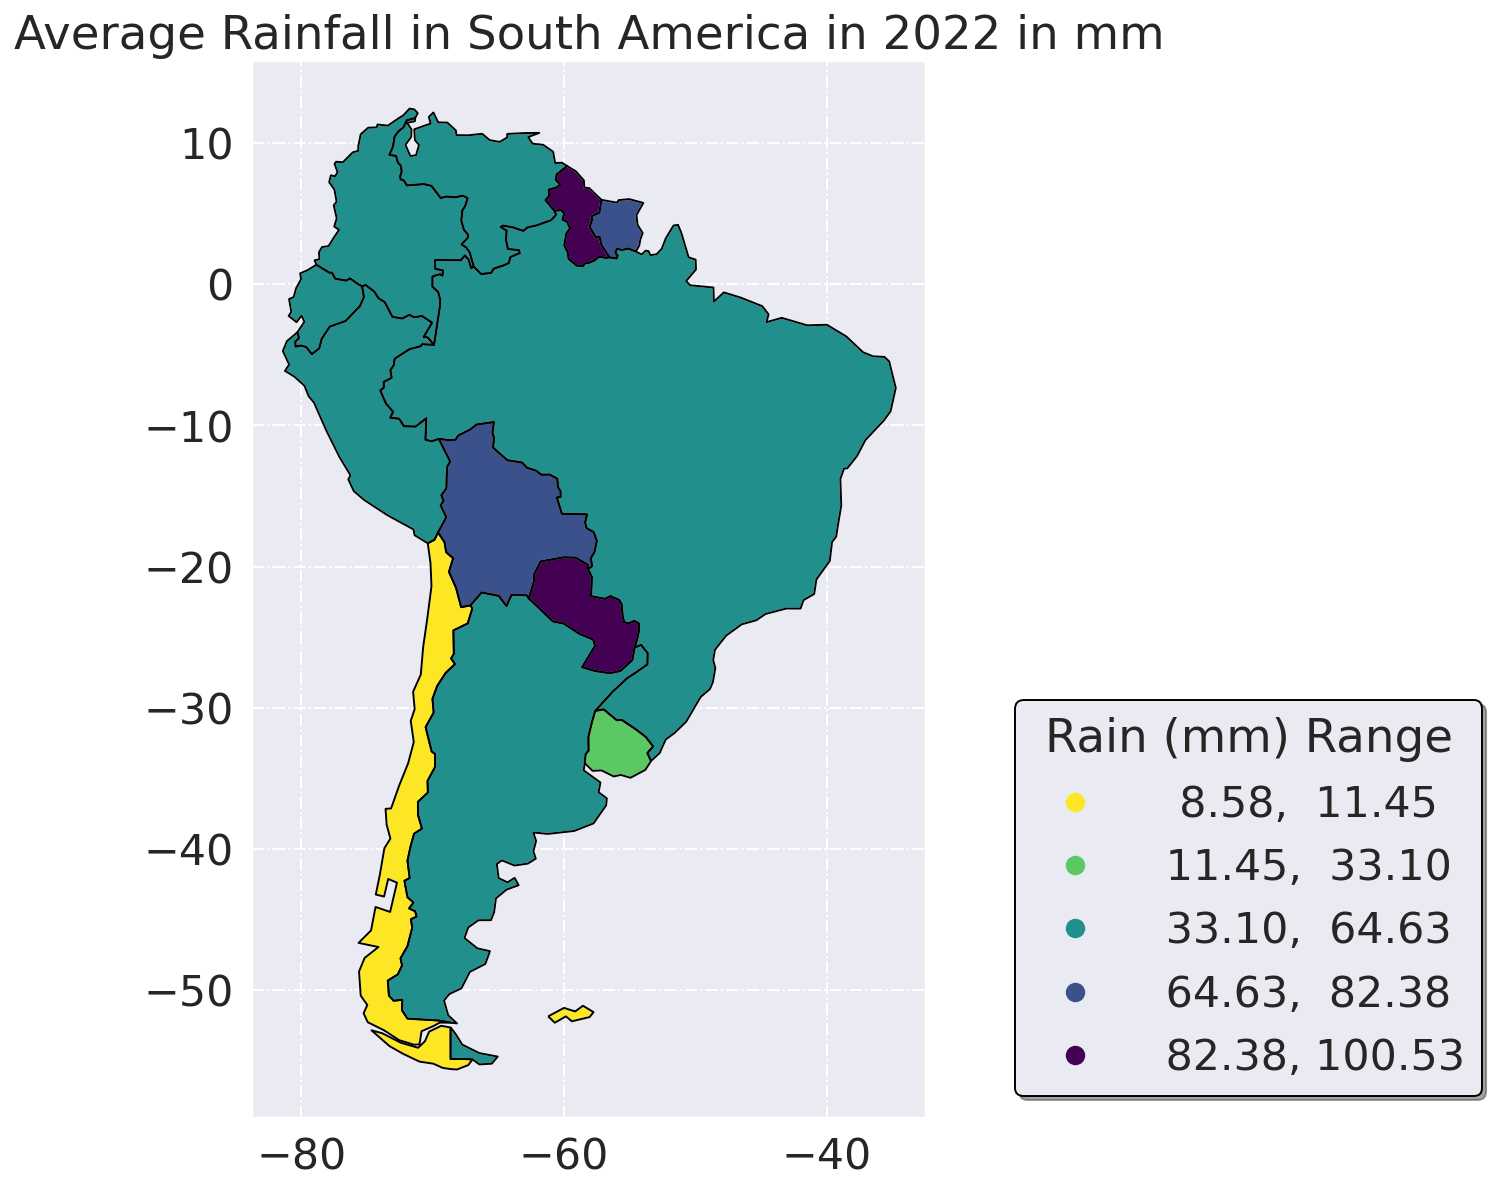

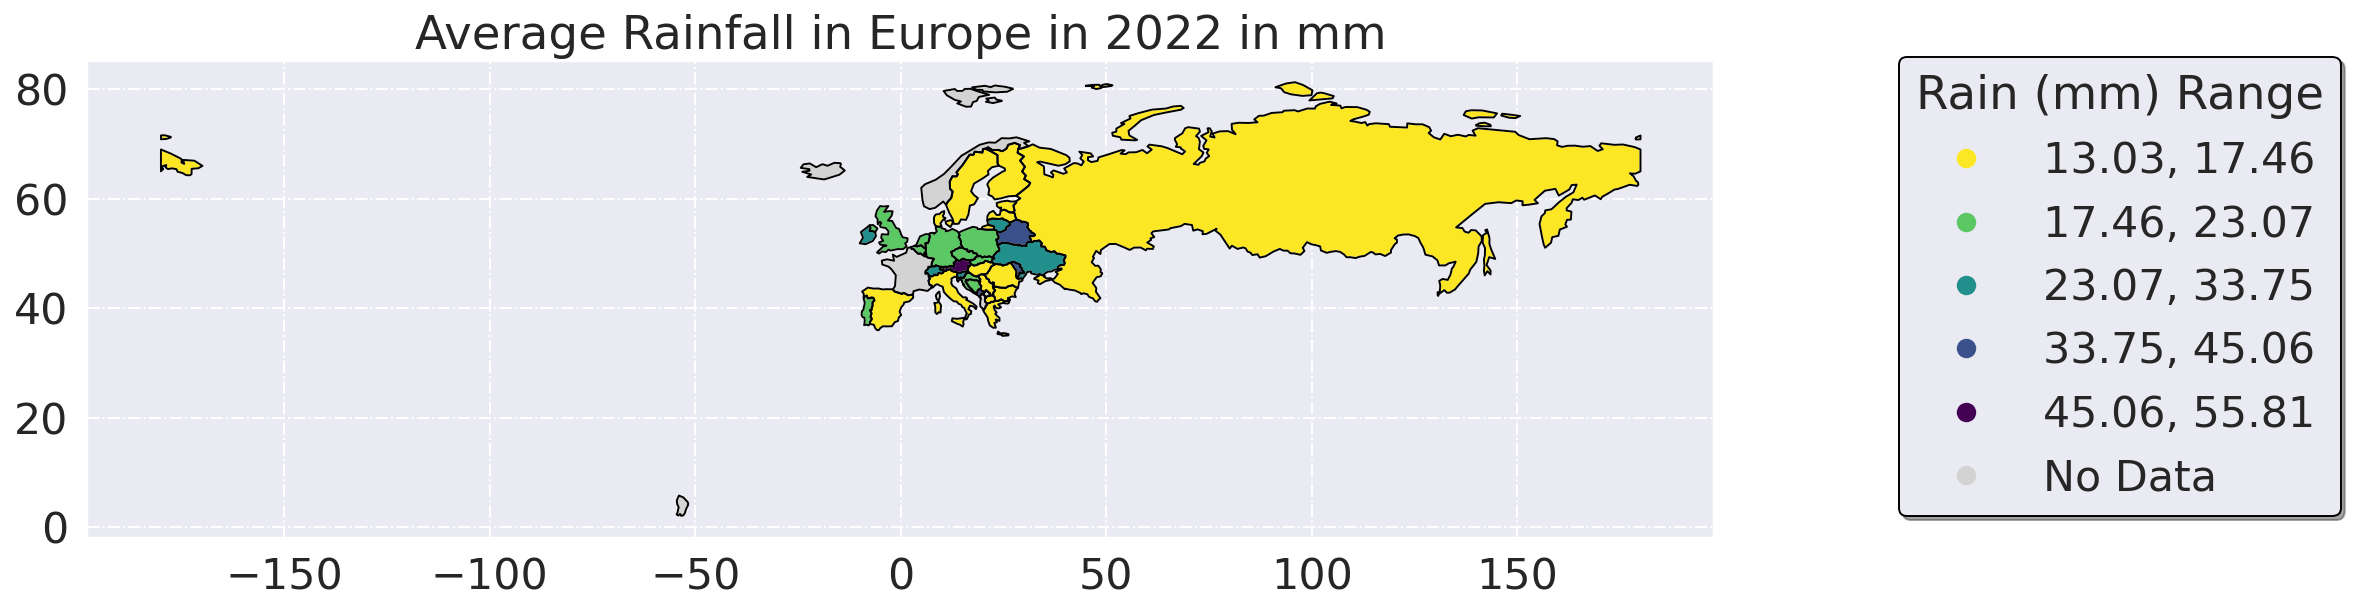

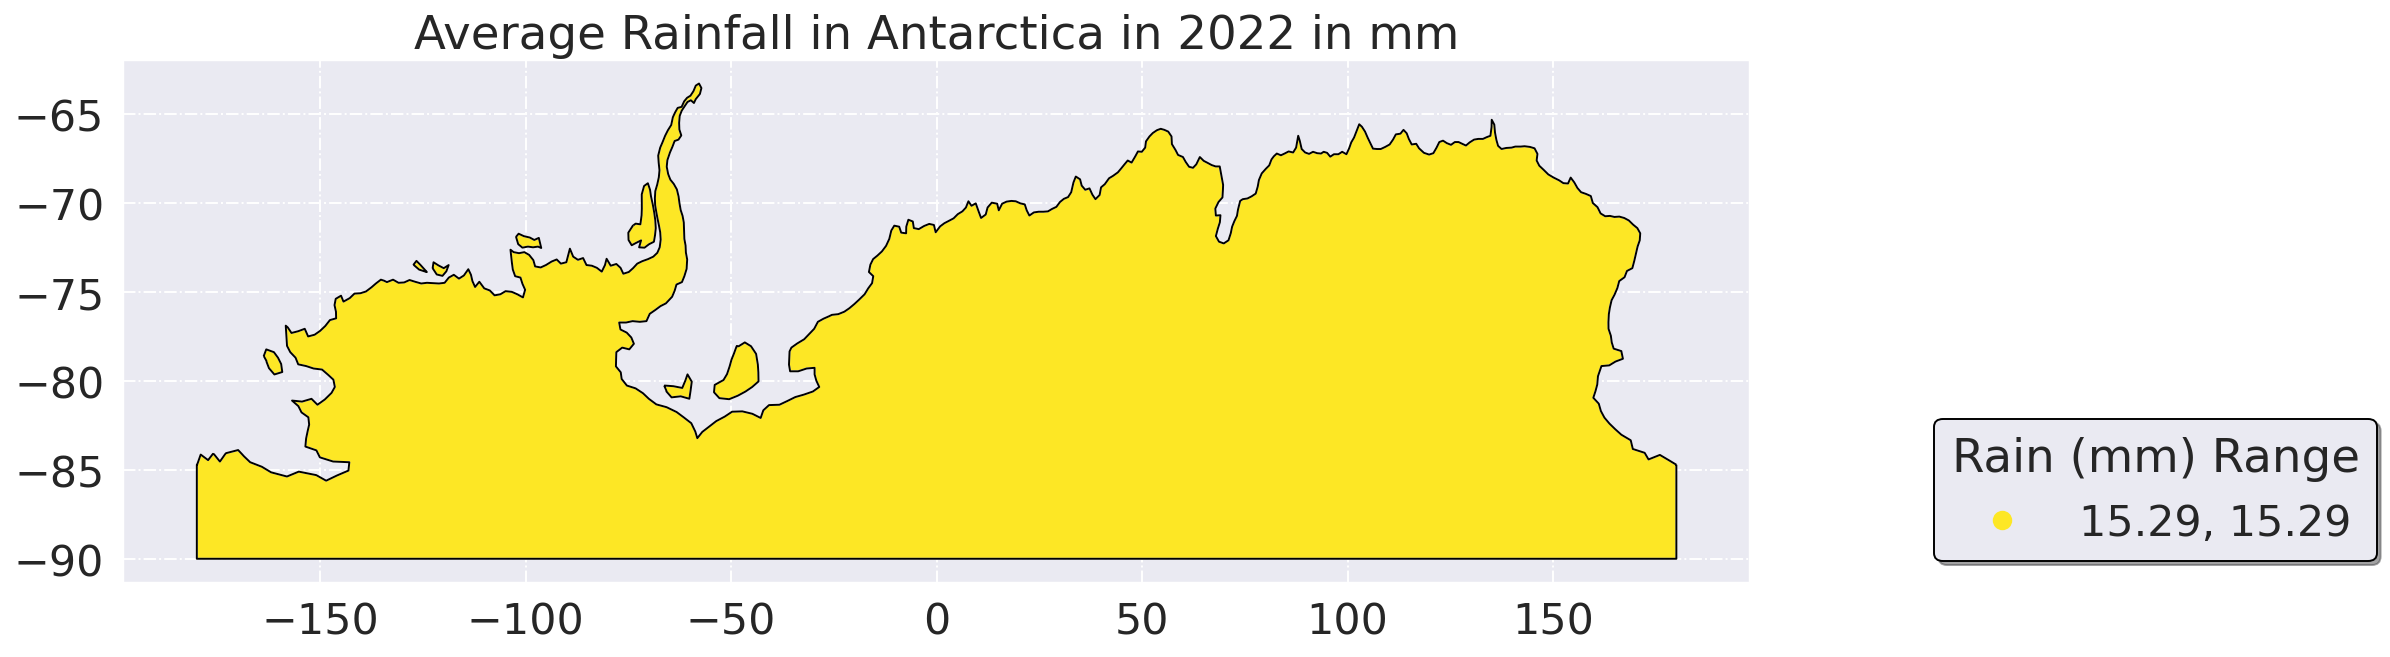

In [106]:
# plot it

# set backdrop as geopandas world map
ax=world_gpd.plot(edgecolor="black", facecolor="none",figsize=(15, 10), zorder=5)

# station locations on the globe. doing this also per continent was too much
# with not enough time do do it

    

# plot averages across world first, on top of gpd map. 
# i really should have named my stuff better here, oh well
world_rain.plot(ax=ax, column="AvgRain_mm", 
                cmap="viridis_r", legend=True, 
                legend_kwds={"loc":"lower left", 
                             "frameon": "True", 
                             "edgecolor":"black",
                             "shadow":"True",
                             "title":"Rain (mm) Range",
                             "title_fontsize":"medium", 'bbox_to_anchor': (1.1,0)}, 
                k=10, scheme="naturalbreaks", 
                missing_kwds={"color":"lightgrey","label":"No Data"}) # if no rain data, fills polygon with grey
# g'bless actually readable documentation on geopandas

# make it reasonably nice, i am in the geospatial program after all
plt.grid(visible=True, linestyle="-.")
plt.title("Average Rainfall in 2022 in mm", fontsize=35)
plt.rcParams["figure.dpi"] = 140

groups=stations_pandas.groupby("Country_Code")
for code, group in groups:
    ax.plot(group.Lon, group.Lat, label=code, linestyle="", marker=",", zorder=4)

plt.savefig('2022_Avg_Precip_worldwide.pdf', format="pdf", bbox_inches="tight")

# set a list of continents derrived from geopandas to show each continent in more detail than world map gives
continents=world_gpd.continent.unique().tolist()
# remove ocean polygon (had to check df info to find exact name of polygon to remove)
continents.remove('Seven seas (open ocean)')

# loop over each continent to plot rain data for just that cont
# some fig sizes are a little strange but its hard to make a uniform figsize for a loop like this
for continent in continents:
    
    #some funky stuff to get the borders to show up between countries
    f=world_rain[world_rain.continent == continent]
    # lazy m for map
    m=world_rain[world_rain.continent == continent].plot(edgecolor="black", facecolor="none",figsize=(15, 10), zorder=5)
   

    # i'm very cranky about this. Geopandas throws an error if you try to 
    # use the "missing_kwds" argument if there ISNT any data missing
    # and at least 1 continent has no missing data so I had to do if statements
    if any(f["AvgRain_mm"].isna())==True:

        f.plot(ax=m,
            column="AvgRain_mm", 
            cmap="viridis_r", 
            legend=True, 
            legend_kwds={
                "loc":"lower left", 
                "frameon": "True",
                "edgecolor":"black",
                "shadow":"True",
                "title":"Rain (mm) Range",
                "title_fontsize":"medium",
                'bbox_to_anchor': (1.1,0)}, 
            scheme="naturalbreaks", 
            missing_kwds={"color":"lightgrey","label":"No Data"})

        
    # the elif for the one continent that had to be annoying and have no missing data (thanks antarctica)
    
    elif any(f["AvgRain_mm"].isna())==False:

        f.plot(ax=m, column="AvgRain_mm", 
                    cmap="viridis_r", legend=True, 
                    legend_kwds={"loc":"lower left", 
                                 "frameon": "True", 
                                 "edgecolor":"black",
                                 "shadow":"True",
                                 "title":"Rain (mm) Range",
                                 "title_fontsize":"medium",
                                 'bbox_to_anchor': (1.1,0)}, 
                    scheme="naturalbreaks")
    
    
    # make it nice looking in looped maps
    plt.rcParams["figure.dpi"] = 140
    plt.title("Average Rainfall in "+continent+" in 2022 in mm")
    plt.grid(visible=True, linestyle="-.")
    
    plt.savefig('2022_Avg_Precip_'+continent+'.pdf', format="pdf", bbox_inches="tight")

In [107]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()